Income distribution of people obtaining Lending Club loans
--

Income distributions from Lending club data are fitted as an alpha distrubution.

Lending club publish their data at https://www.lendingclub.com/info/download-data.action


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

To get the data, run the getdata.sh script in the data/ directory.

In [2]:
df_loans = pd.read_csv('data/LoanStats_2017Q1.csv', low_memory=False, skiprows=1)

Quick look at income distrubution:

In [3]:
df_loans['annual_inc'].describe()

count    9.677900e+04
mean     8.276104e+04
std      2.149442e+05
min      0.000000e+00
25%      4.900000e+04
50%      7.000000e+04
75%      9.950000e+04
max      6.100000e+07
Name: annual_inc, dtype: float64

Here are the loan purposes:

In [4]:
loan_purposes = df_loans['purpose'].dropna().unique()
print(loan_purposes)

['debt_consolidation' 'other' 'credit_card' 'vacation' 'medical'
 'home_improvement' 'major_purchase' 'car' 'small_business' 'moving'
 'house' 'renewable_energy']


Income Distribution Model class - using stepwise processor pattern.
--

In [5]:
from scipy.stats import alpha

class IncomeDistributionModel(object):
    """
    Our Income distribution class.
    """
    
    def __init__(self, modelname):
        self.modelname = modelname
        self.data = []
        self.shape = []
        self.loc = []
        self.scale = []
        self.dist = []
        
    def fit(self, data):
        self._add_data(data)
        self._update_model_parameters()
        self._get_dist()
        return self
    
    def inspect(self):
        plt.figure(figsize = (10,6), dpi = 300)
        plt.yscale('log')
        
        binwidth = 10000.
        maxbin = 1e6
        bins = np.arange(0, maxbin + binwidth, binwidth)
           
        histvalues, bins, patches = plt.hist(self.data, bins=bins)
        plt.xlabel('Annual income'+' ($)')

        scale = histvalues.sum() * binwidth
        x = np.linspace(0, maxbin, 200)
        plt.plot(x, self.dist.pdf(x) * scale, 'r-', lw=5, alpha=0.6)
        plt.plot(x, self.dist.pdf(x) * scale, 'k-', lw=2, alpha=0.6)
        plt.axvline(self.dist.median(), color='r', lw=2, linestyle='dashed', linewidth=2)
        plt.title('Model '+self.modelname+' median income is $'+
                  str(int(self.dist.median()/1e3))+'K')
    
    def pdf(self, income):
        return self.dist.pdf(income)
    
    def cdf(self, income):
        return self.dist.cdf(income)
    
    def classify(self, income):
        if self.cdf(income) >  1.0 - 1e-3:
            return 'EXTREME_INCOME'
        else:
            return 'NORMAL_INCOME'
        
    def save():
        pass
    
    def load():
        pass
        
    def _add_data(self, data):
        self.data = data
        return       
    
    def _update_model_parameters(self):
        self.shape, self.loc, self.scale  = alpha.fit(self.data)
        
    def _get_dist(self):
        self.dist = alpha(self.shape, self.loc, self.scale) 

Here we demonstrate how to instantiate the income distribution model and fit it to some incomes.


/Users/leach/anaconda3/envs/py3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2303: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


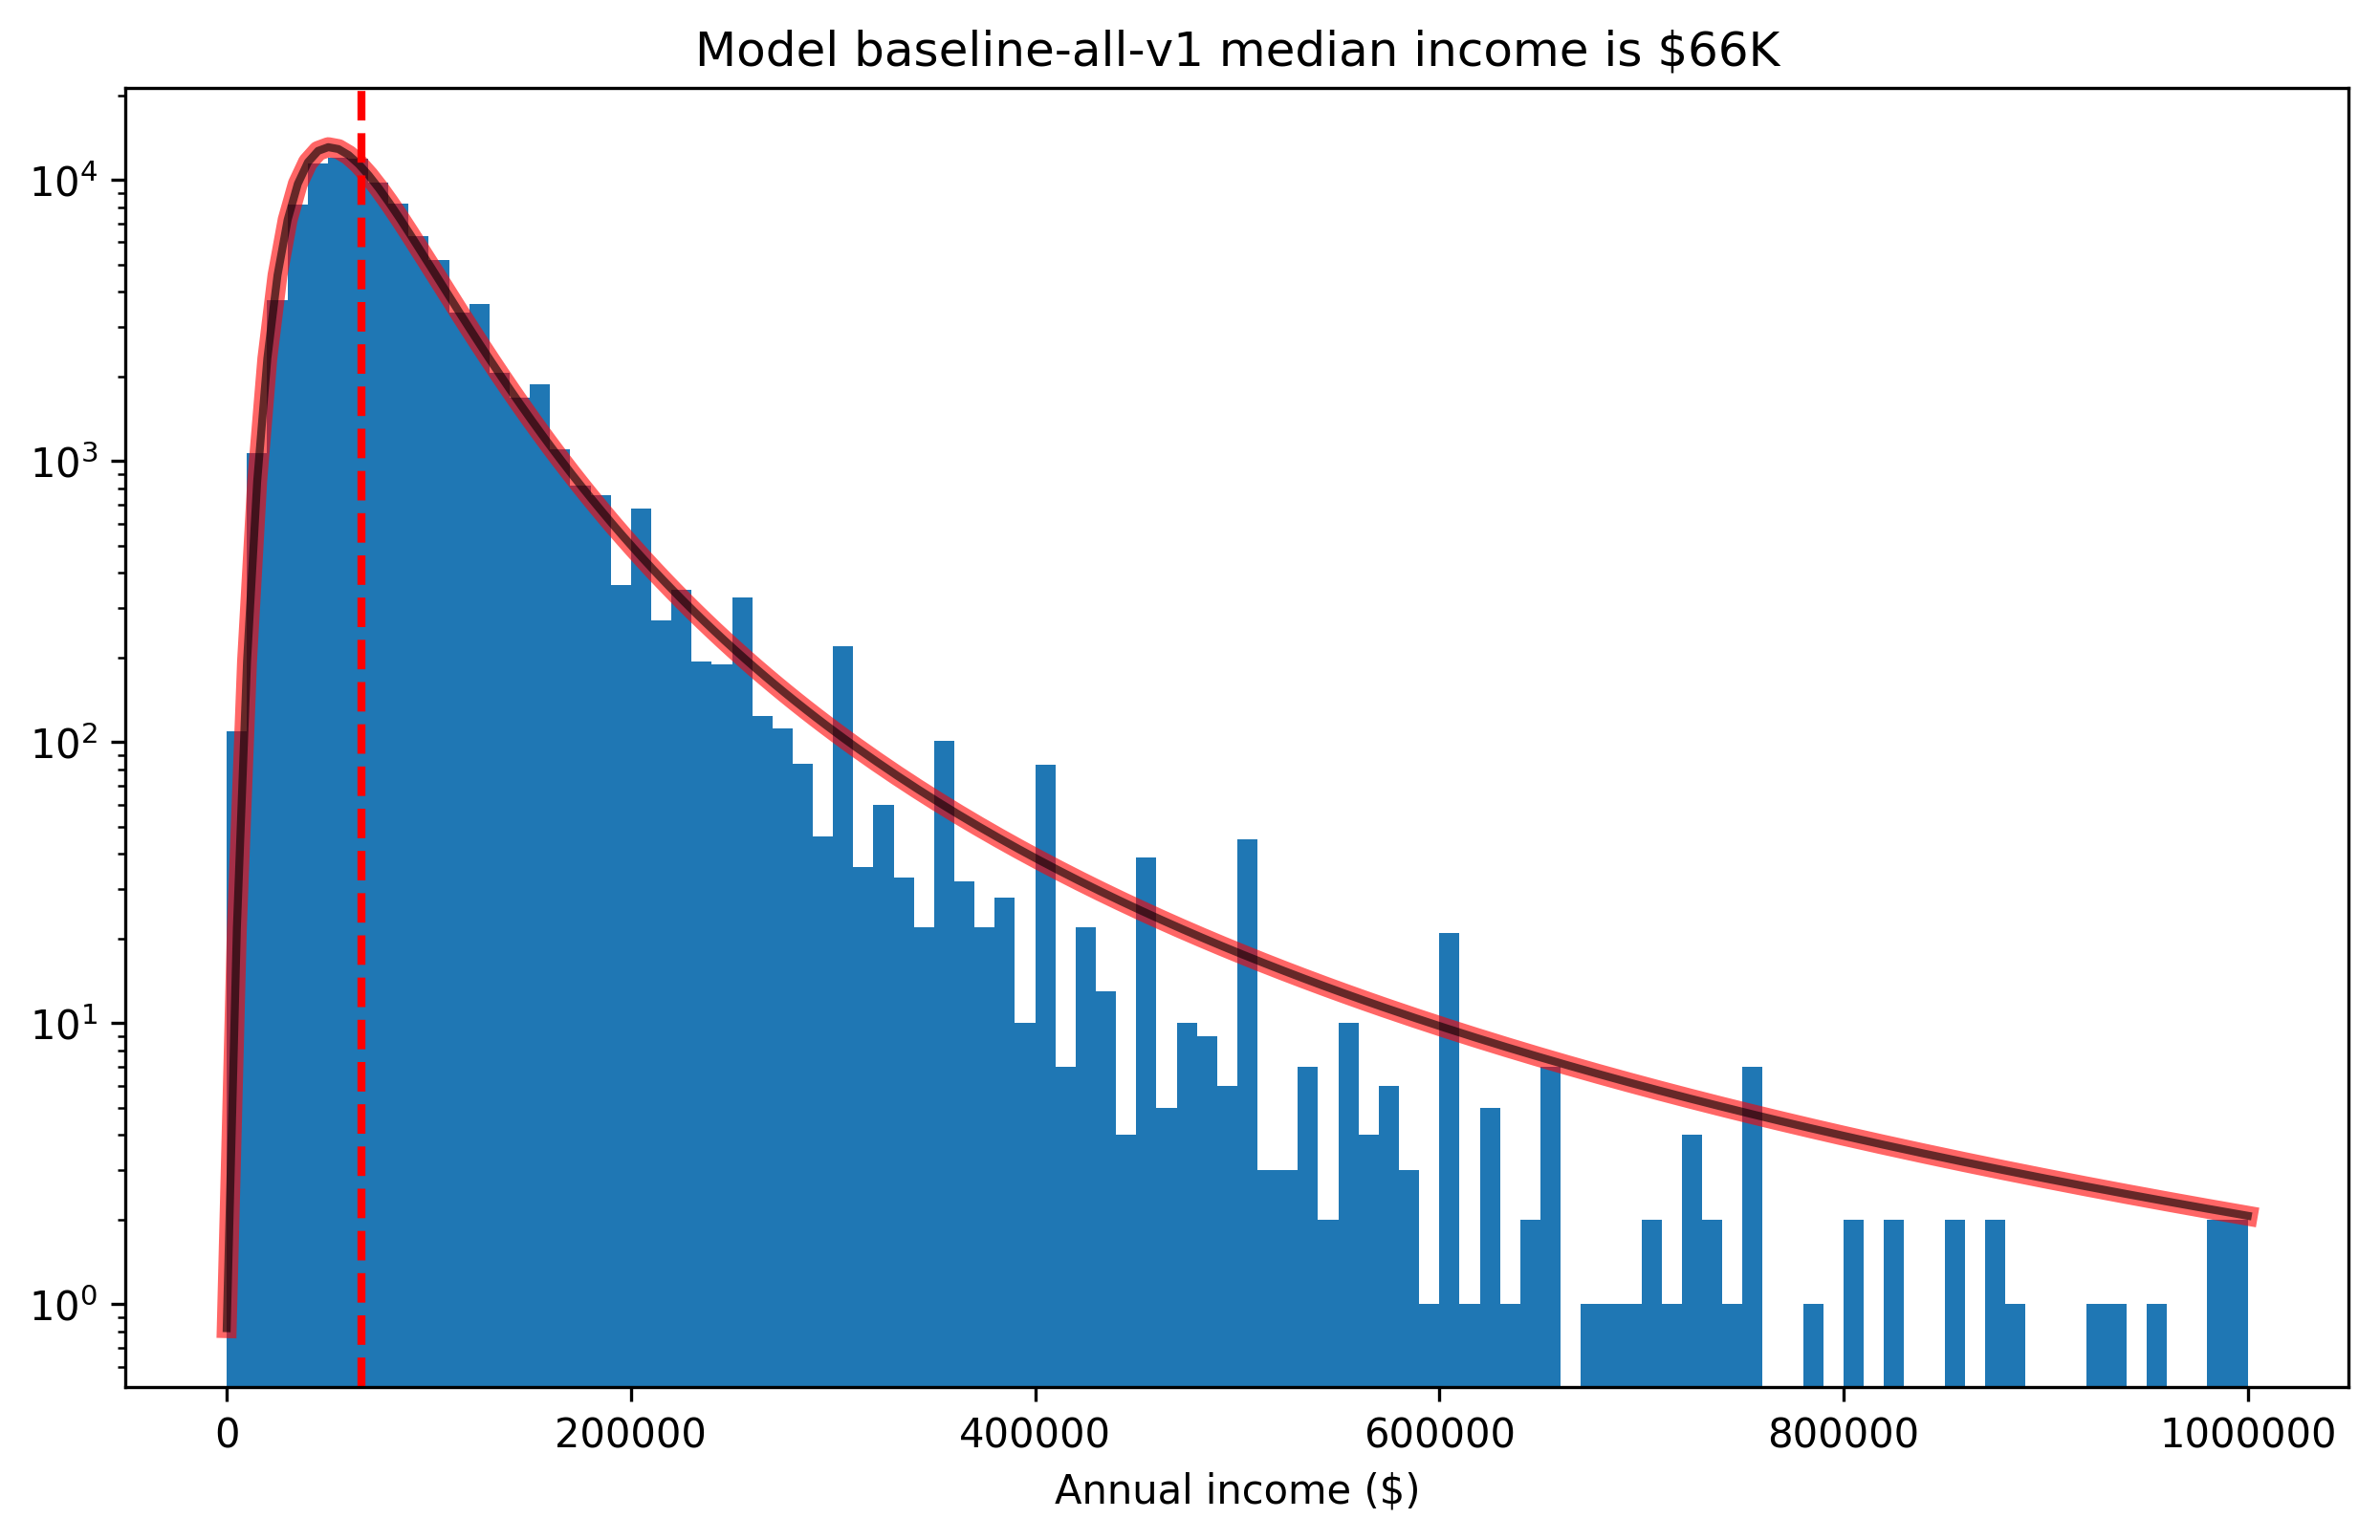

In [6]:
df_income = df_loans['annual_inc'][df_loans['annual_inc'] > 0.]
incomes = df_income.dropna().as_matrix()

myModel = IncomeDistributionModel('baseline-all-v1')
myModel.fit(incomes)
myModel.inspect()

Demonstrates a rule based classifer to label extreme incomes (above the 99.9% percentile of the distribution):

In [7]:
print(myModel.classify(0))
print(myModel.classify(500e3))
print(myModel.classify(800e3))
print(myModel.classify(2000e3))

NORMAL_INCOME
NORMAL_INCOME
NORMAL_INCOME
EXTREME_INCOME


Rerun the modelling as a function of the loan purpose segments:


Loan purpose:debt_consolidation


/Users/leach/anaconda3/envs/py3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2303: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


NORMAL_INCOME
NORMAL_INCOME
EXTREME_INCOME
EXTREME_INCOME

Loan purpose:other
NORMAL_INCOME
NORMAL_INCOME
EXTREME_INCOME
EXTREME_INCOME

Loan purpose:credit_card
NORMAL_INCOME
NORMAL_INCOME
NORMAL_INCOME
NORMAL_INCOME

Loan purpose:vacation
NORMAL_INCOME
NORMAL_INCOME
EXTREME_INCOME
EXTREME_INCOME

Loan purpose:medical
NORMAL_INCOME
NORMAL_INCOME
EXTREME_INCOME
EXTREME_INCOME

Loan purpose:home_improvement
NORMAL_INCOME
NORMAL_INCOME
NORMAL_INCOME
EXTREME_INCOME

Loan purpose:major_purchase
NORMAL_INCOME
NORMAL_INCOME
EXTREME_INCOME
EXTREME_INCOME

Loan purpose:car
NORMAL_INCOME
NORMAL_INCOME
NORMAL_INCOME
NORMAL_INCOME

Loan purpose:small_business
NORMAL_INCOME
NORMAL_INCOME
NORMAL_INCOME
EXTREME_INCOME

Loan purpose:moving
NORMAL_INCOME
EXTREME_INCOME
EXTREME_INCOME
EXTREME_INCOME

Loan purpose:house
NORMAL_INCOME
NORMAL_INCOME
NORMAL_INCOME
NORMAL_INCOME

Loan purpose:renewable_energy
NORMAL_INCOME
NORMAL_INCOME
NORMAL_INCOME
EXTREME_INCOME


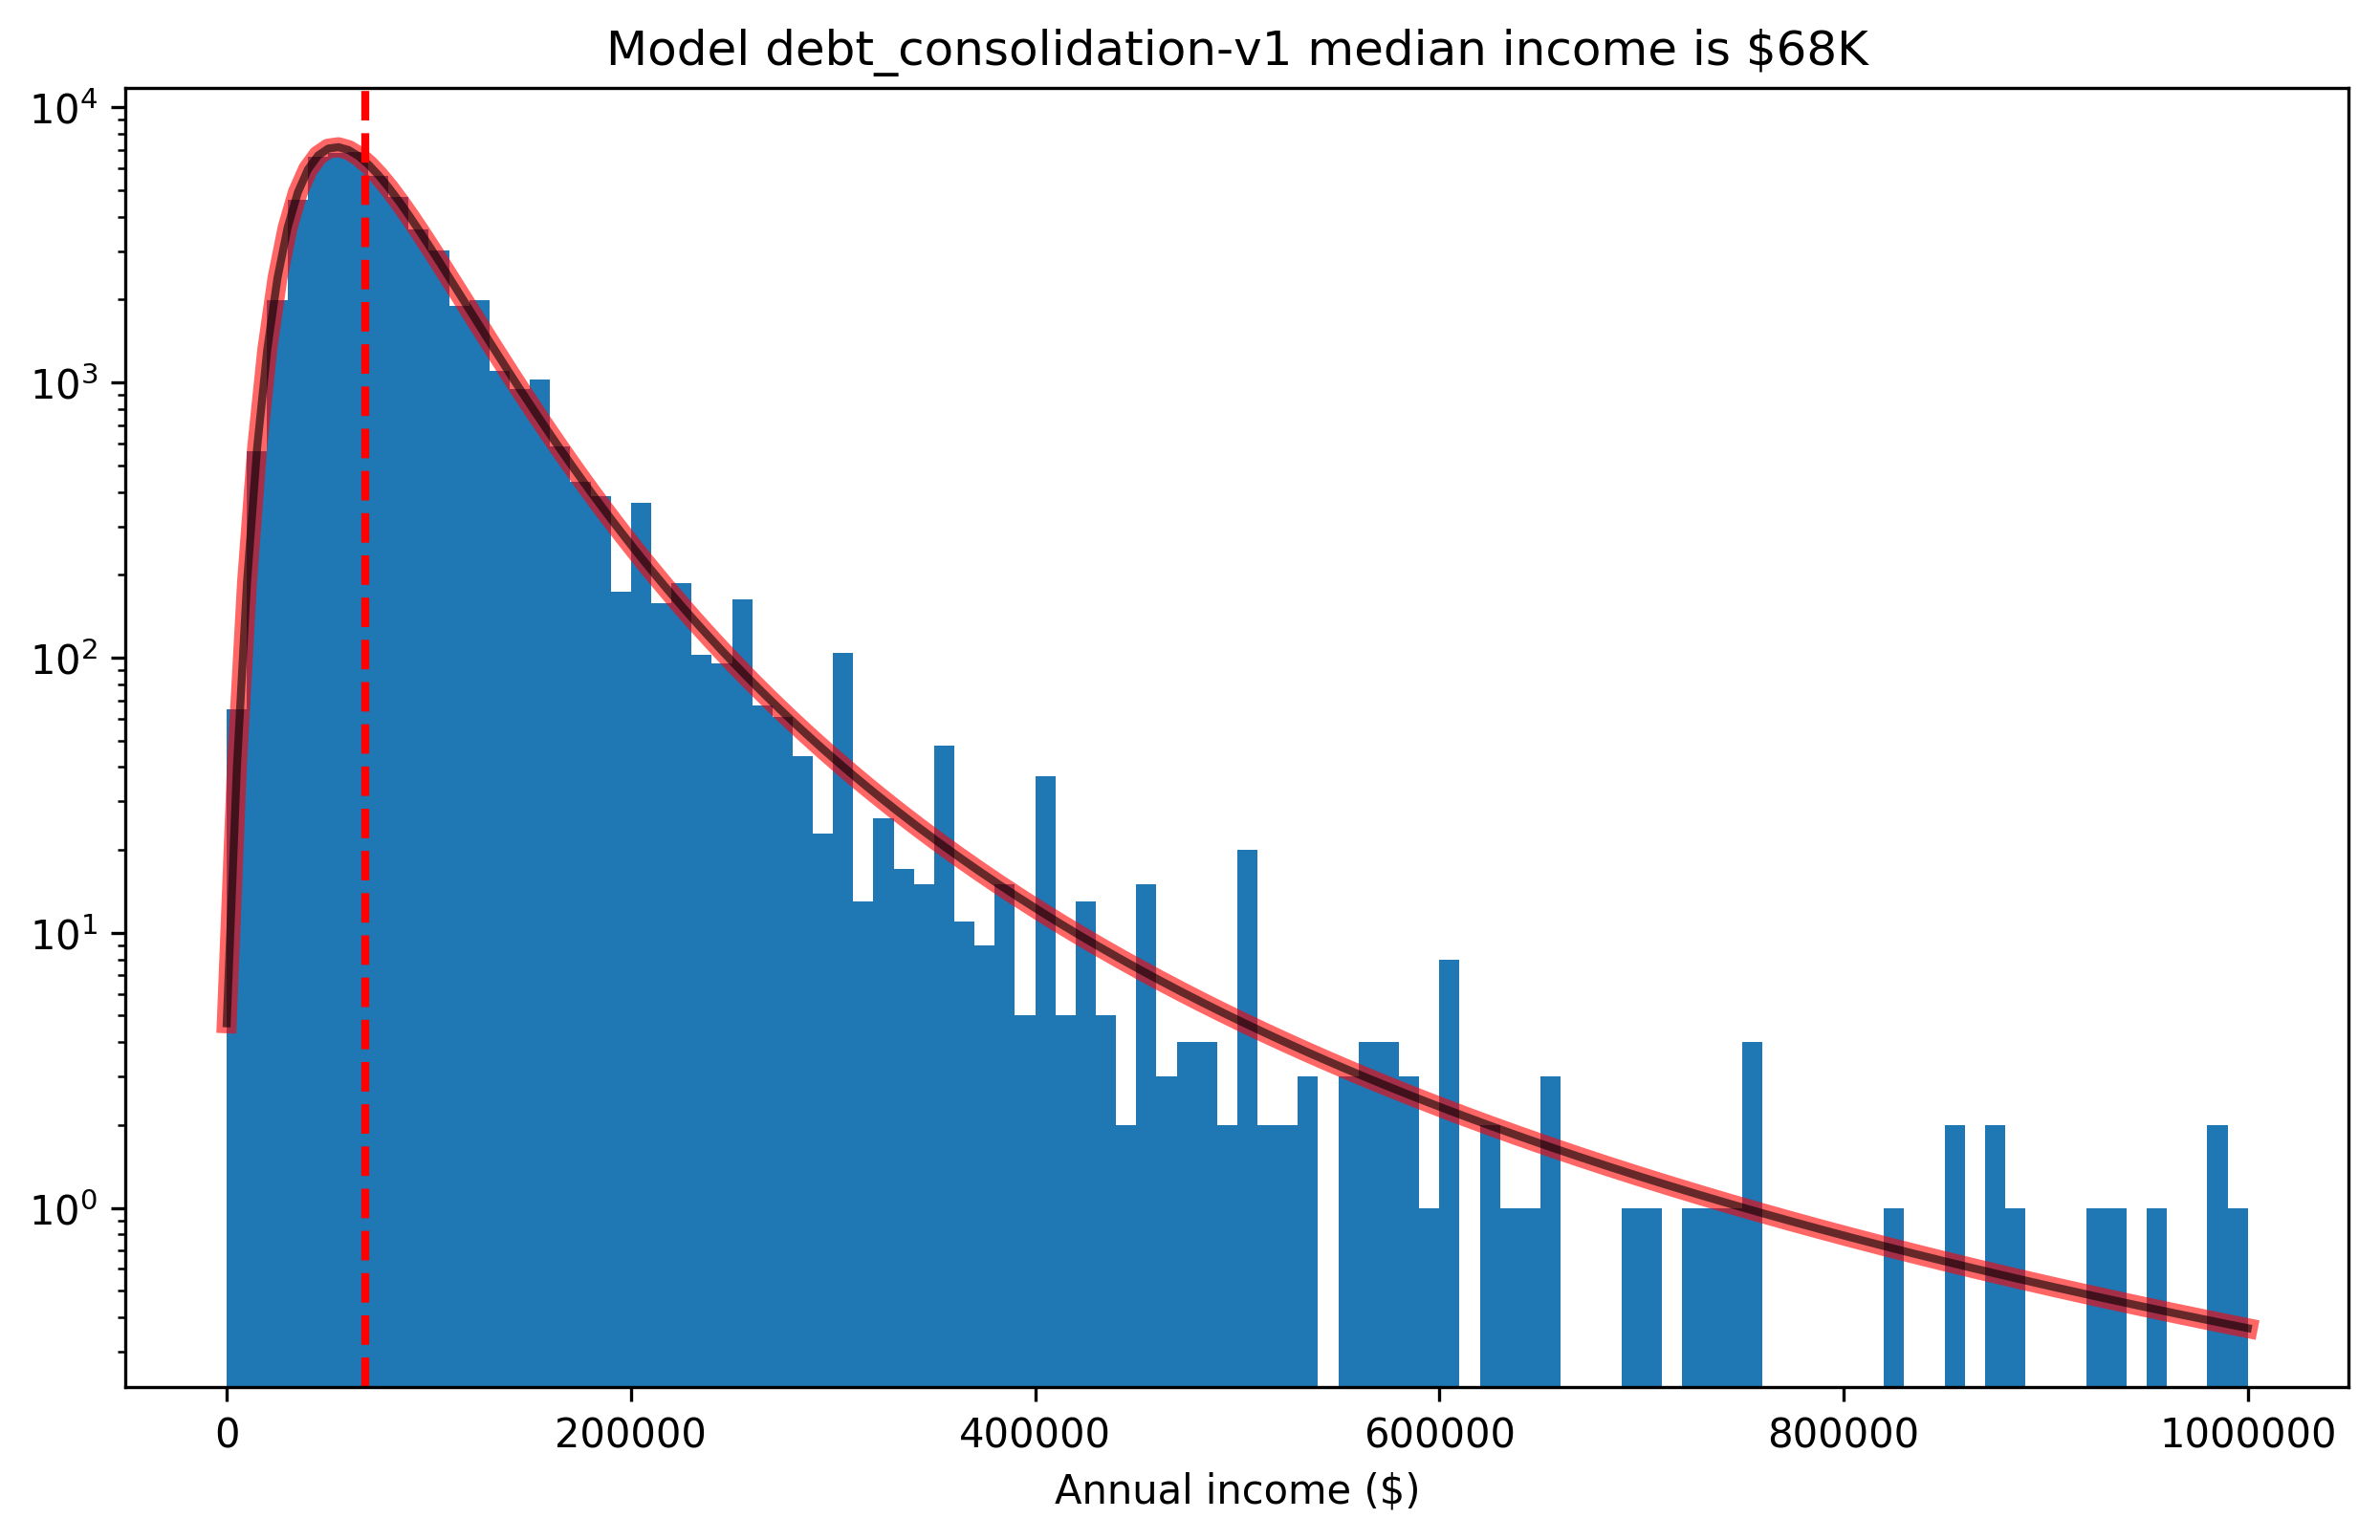

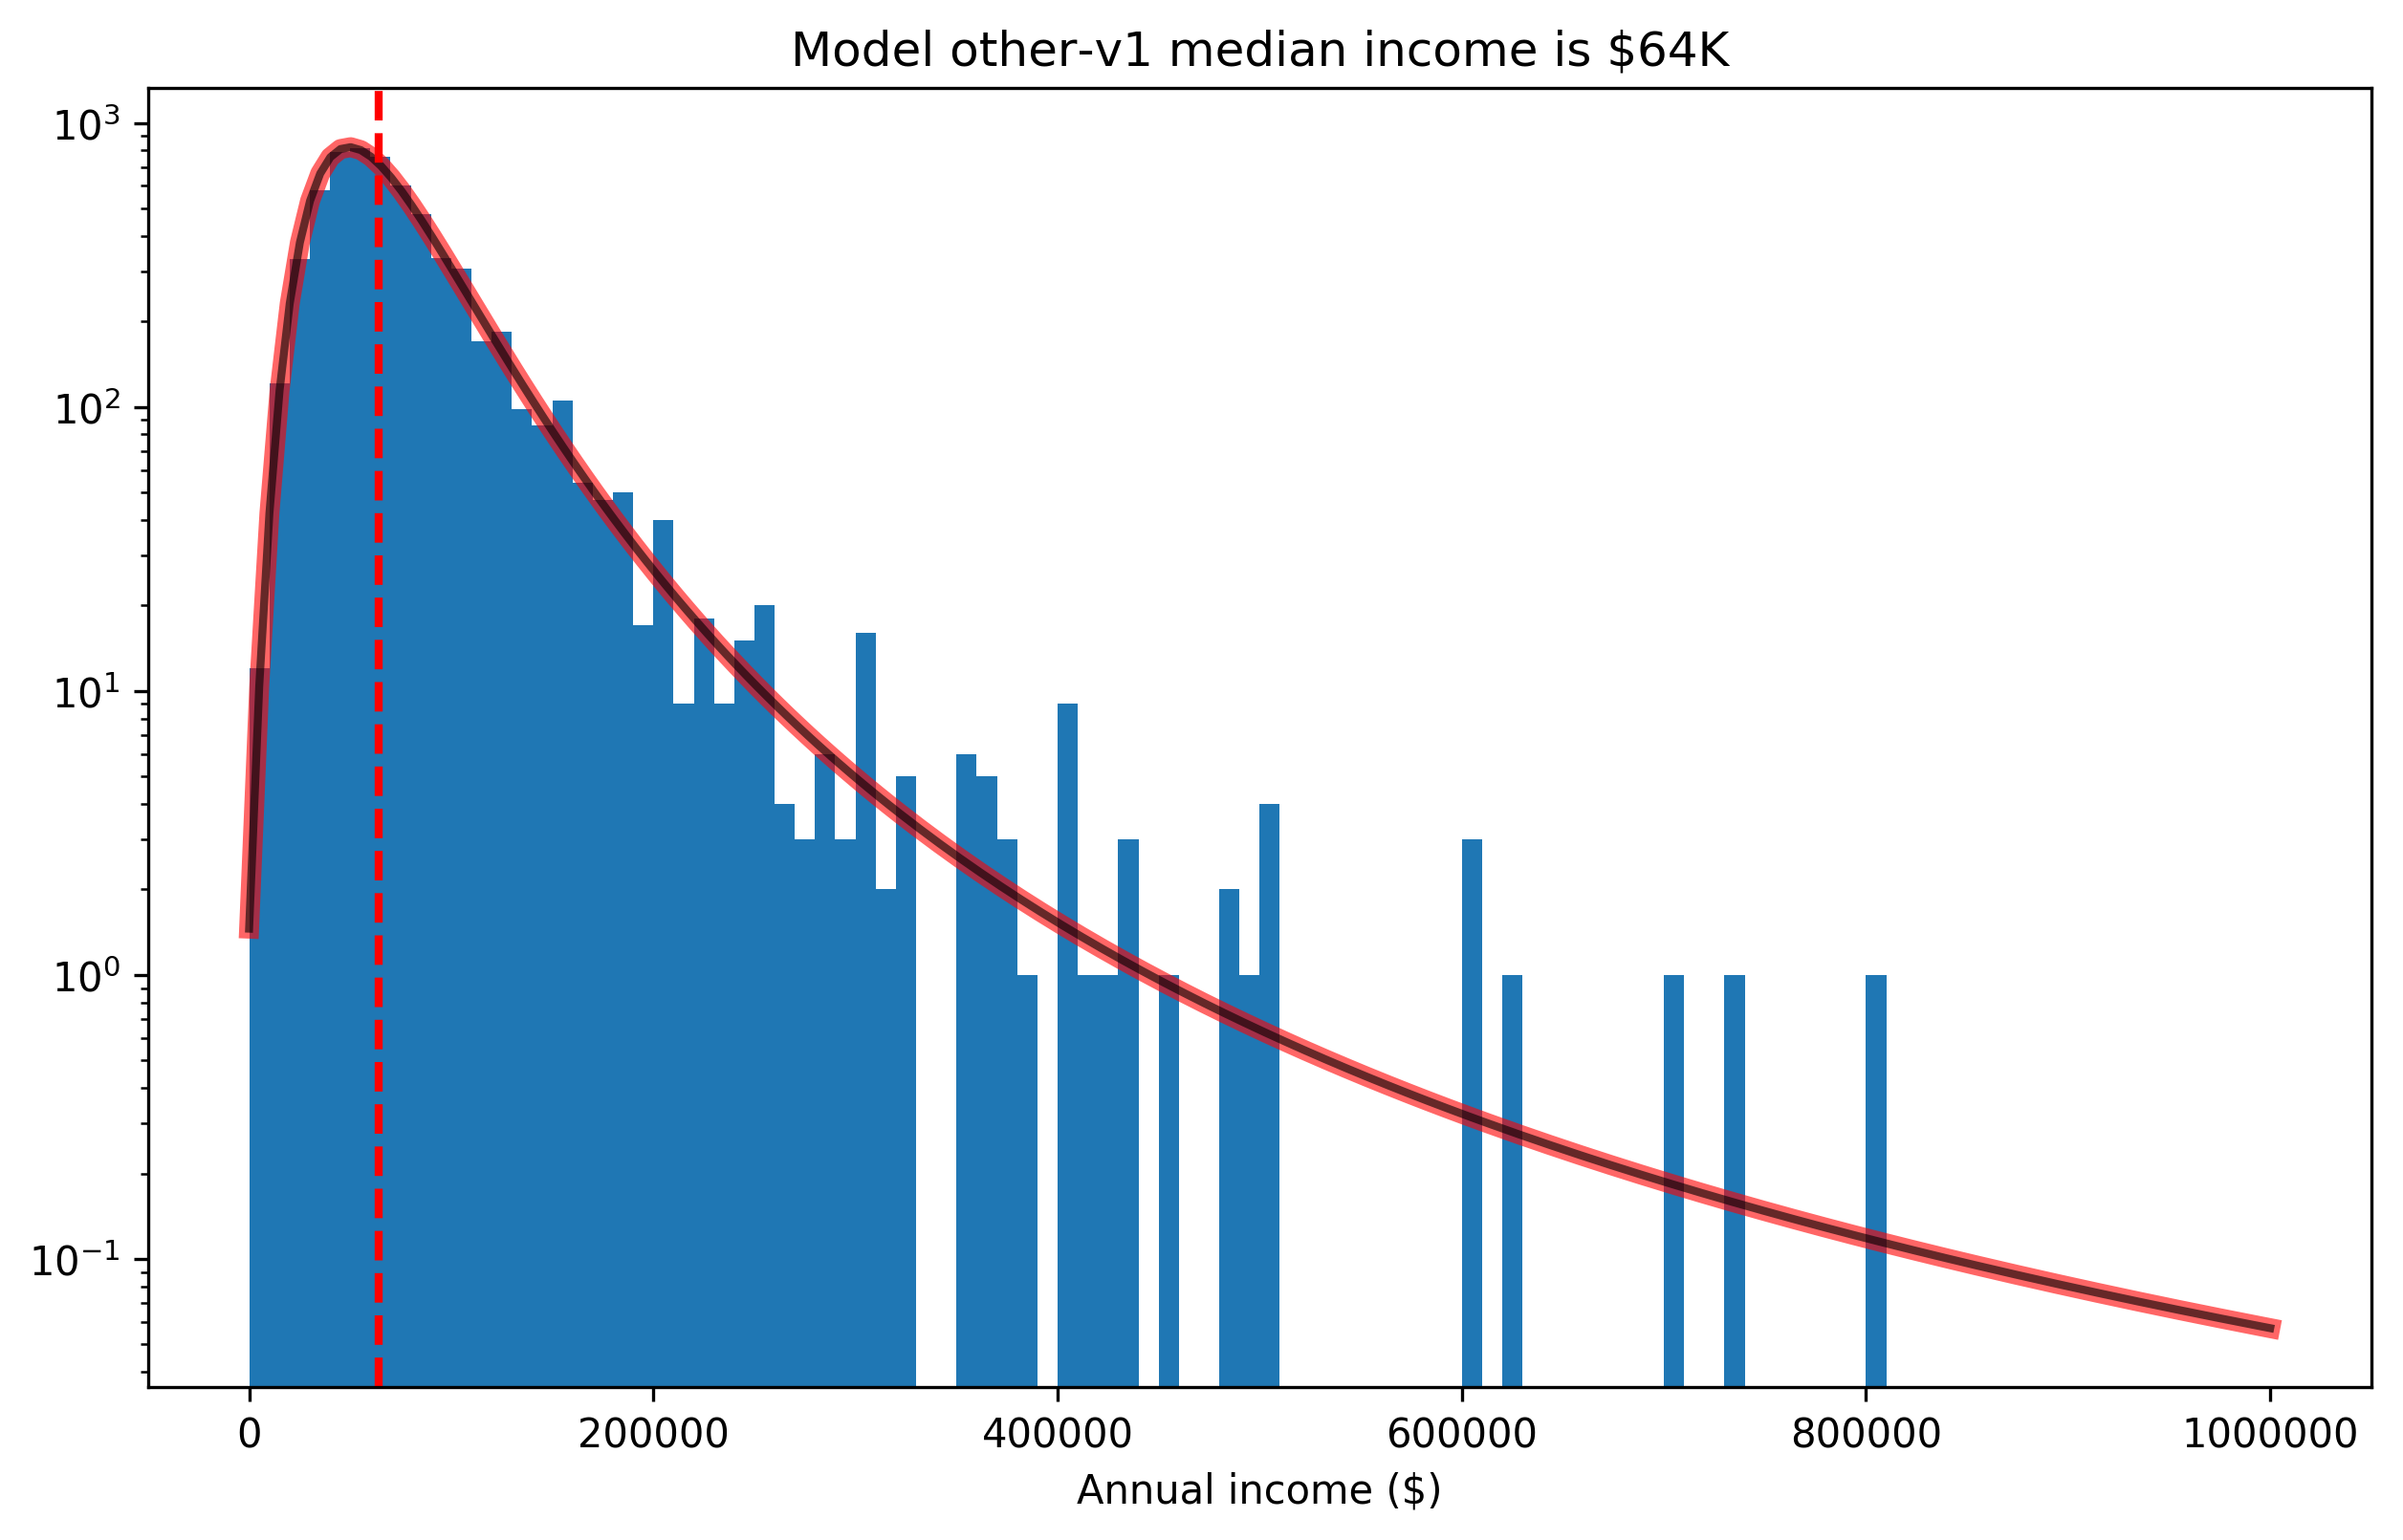

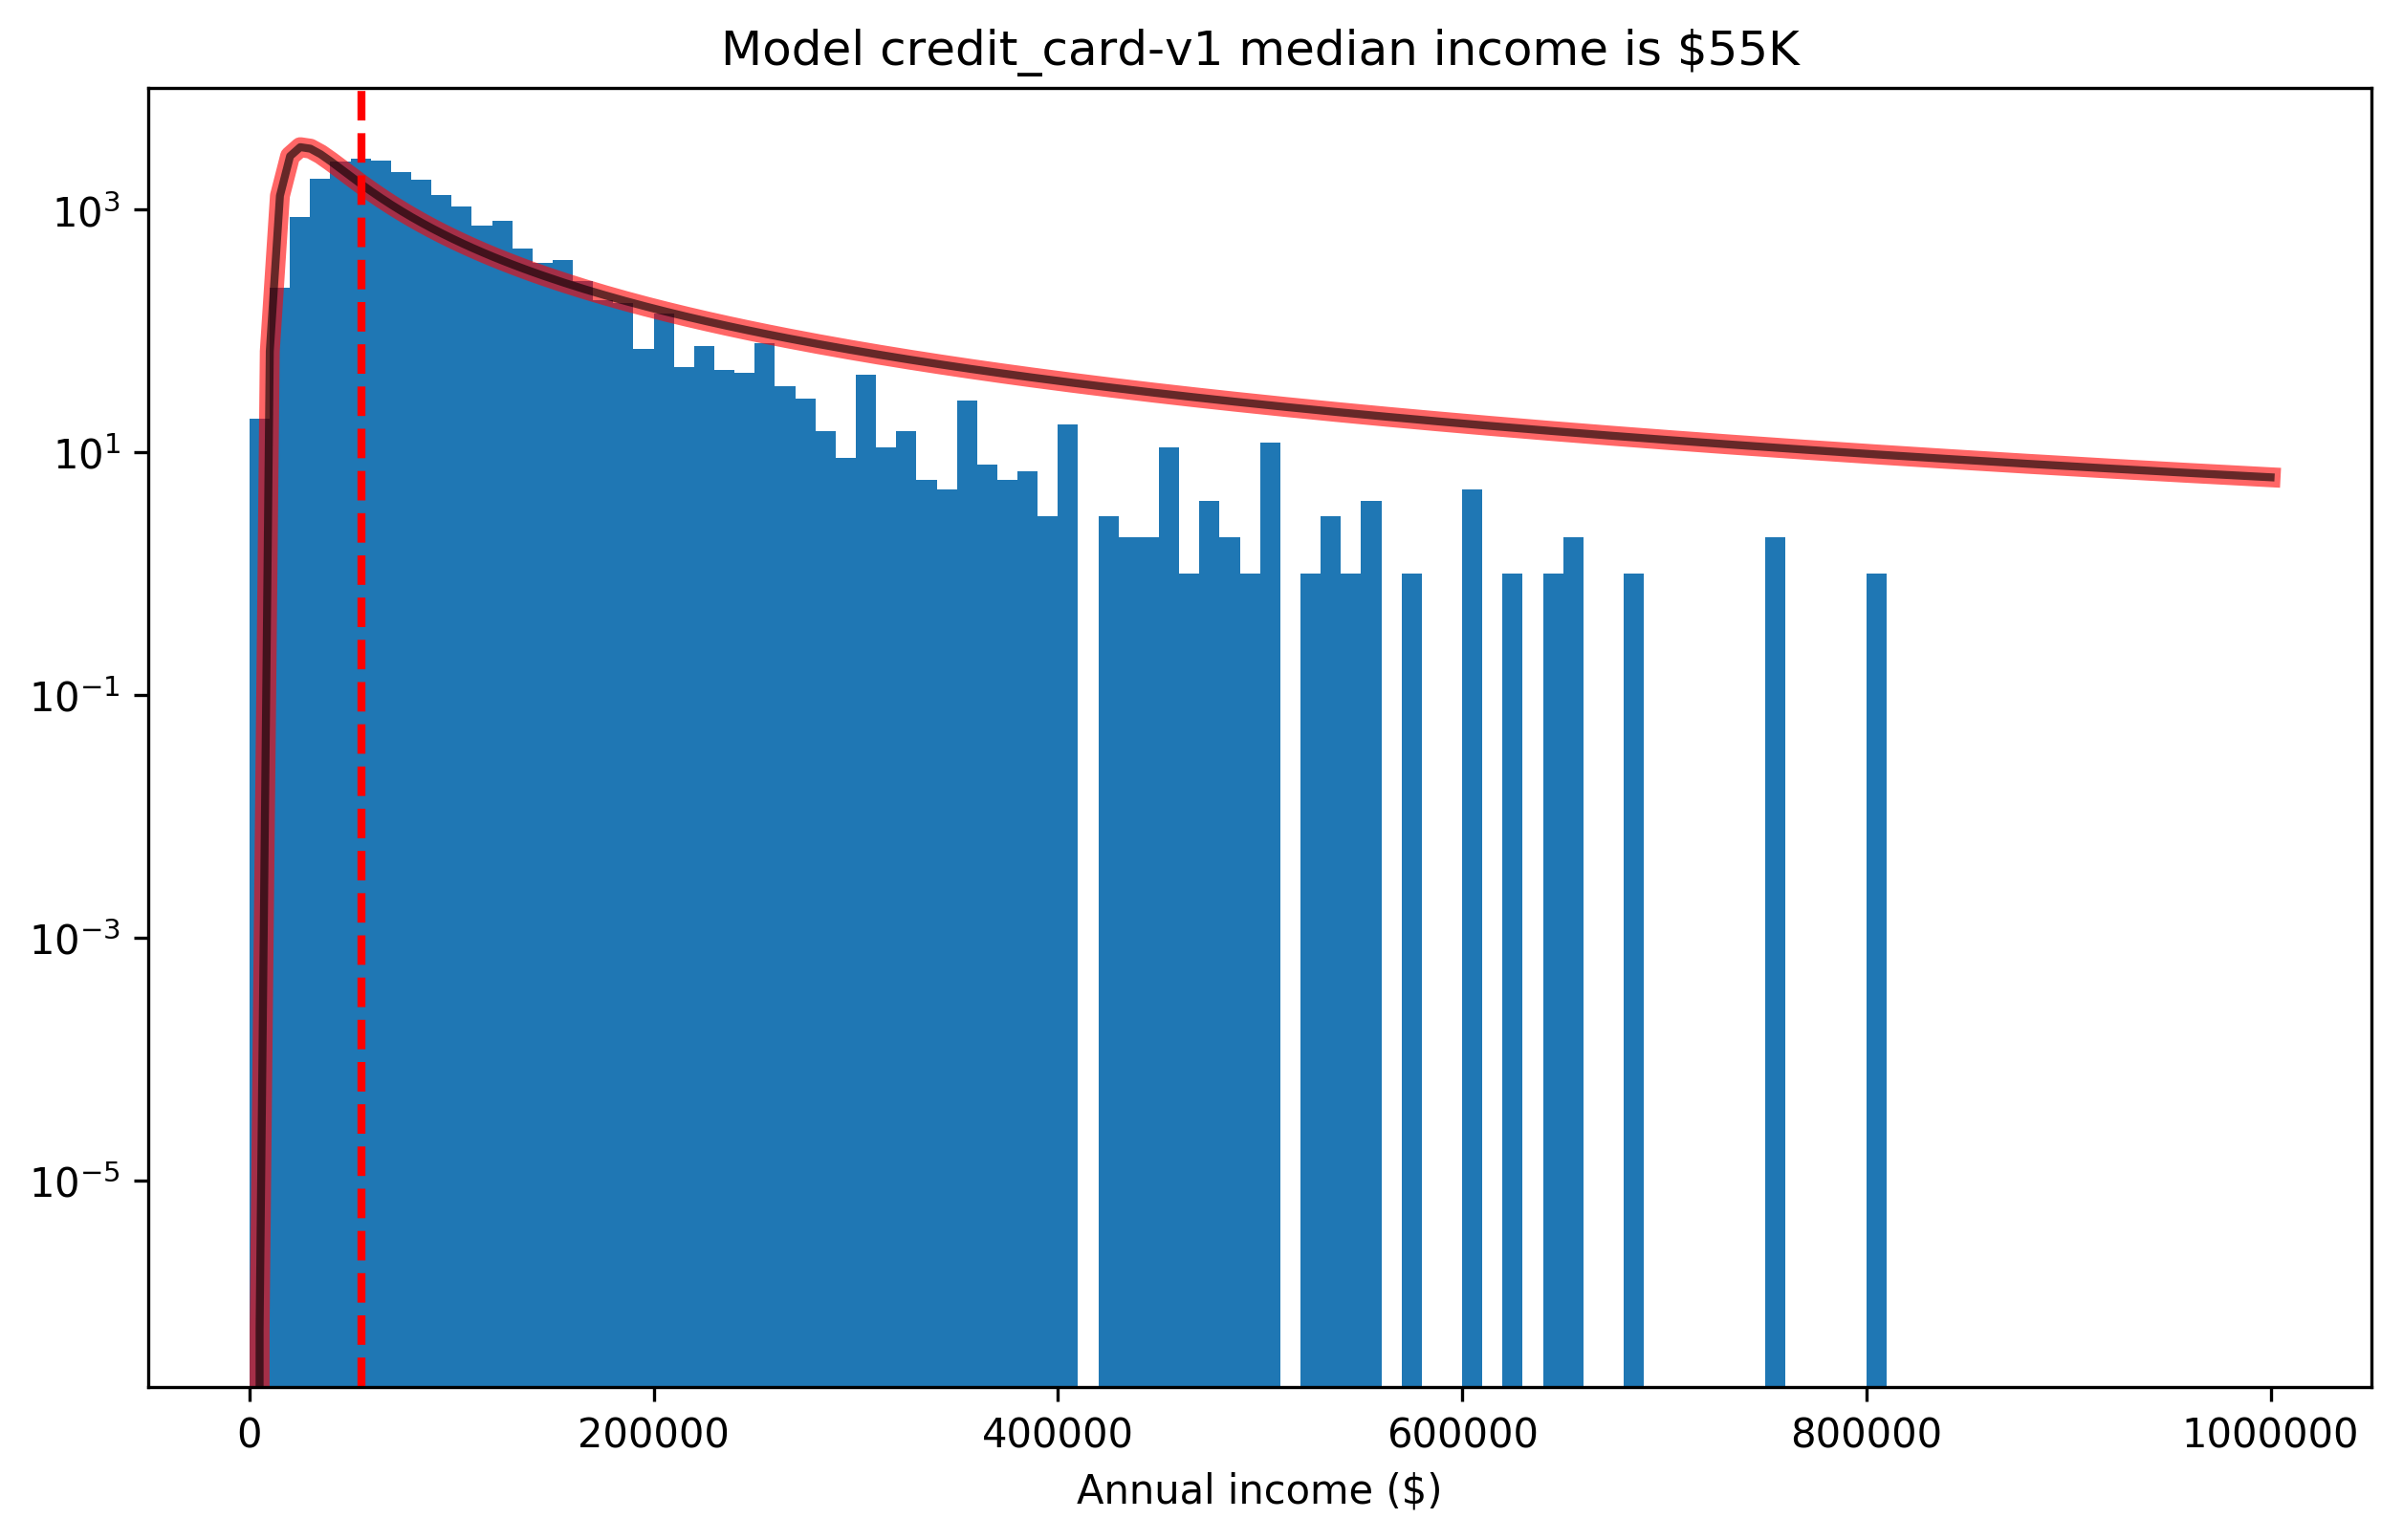

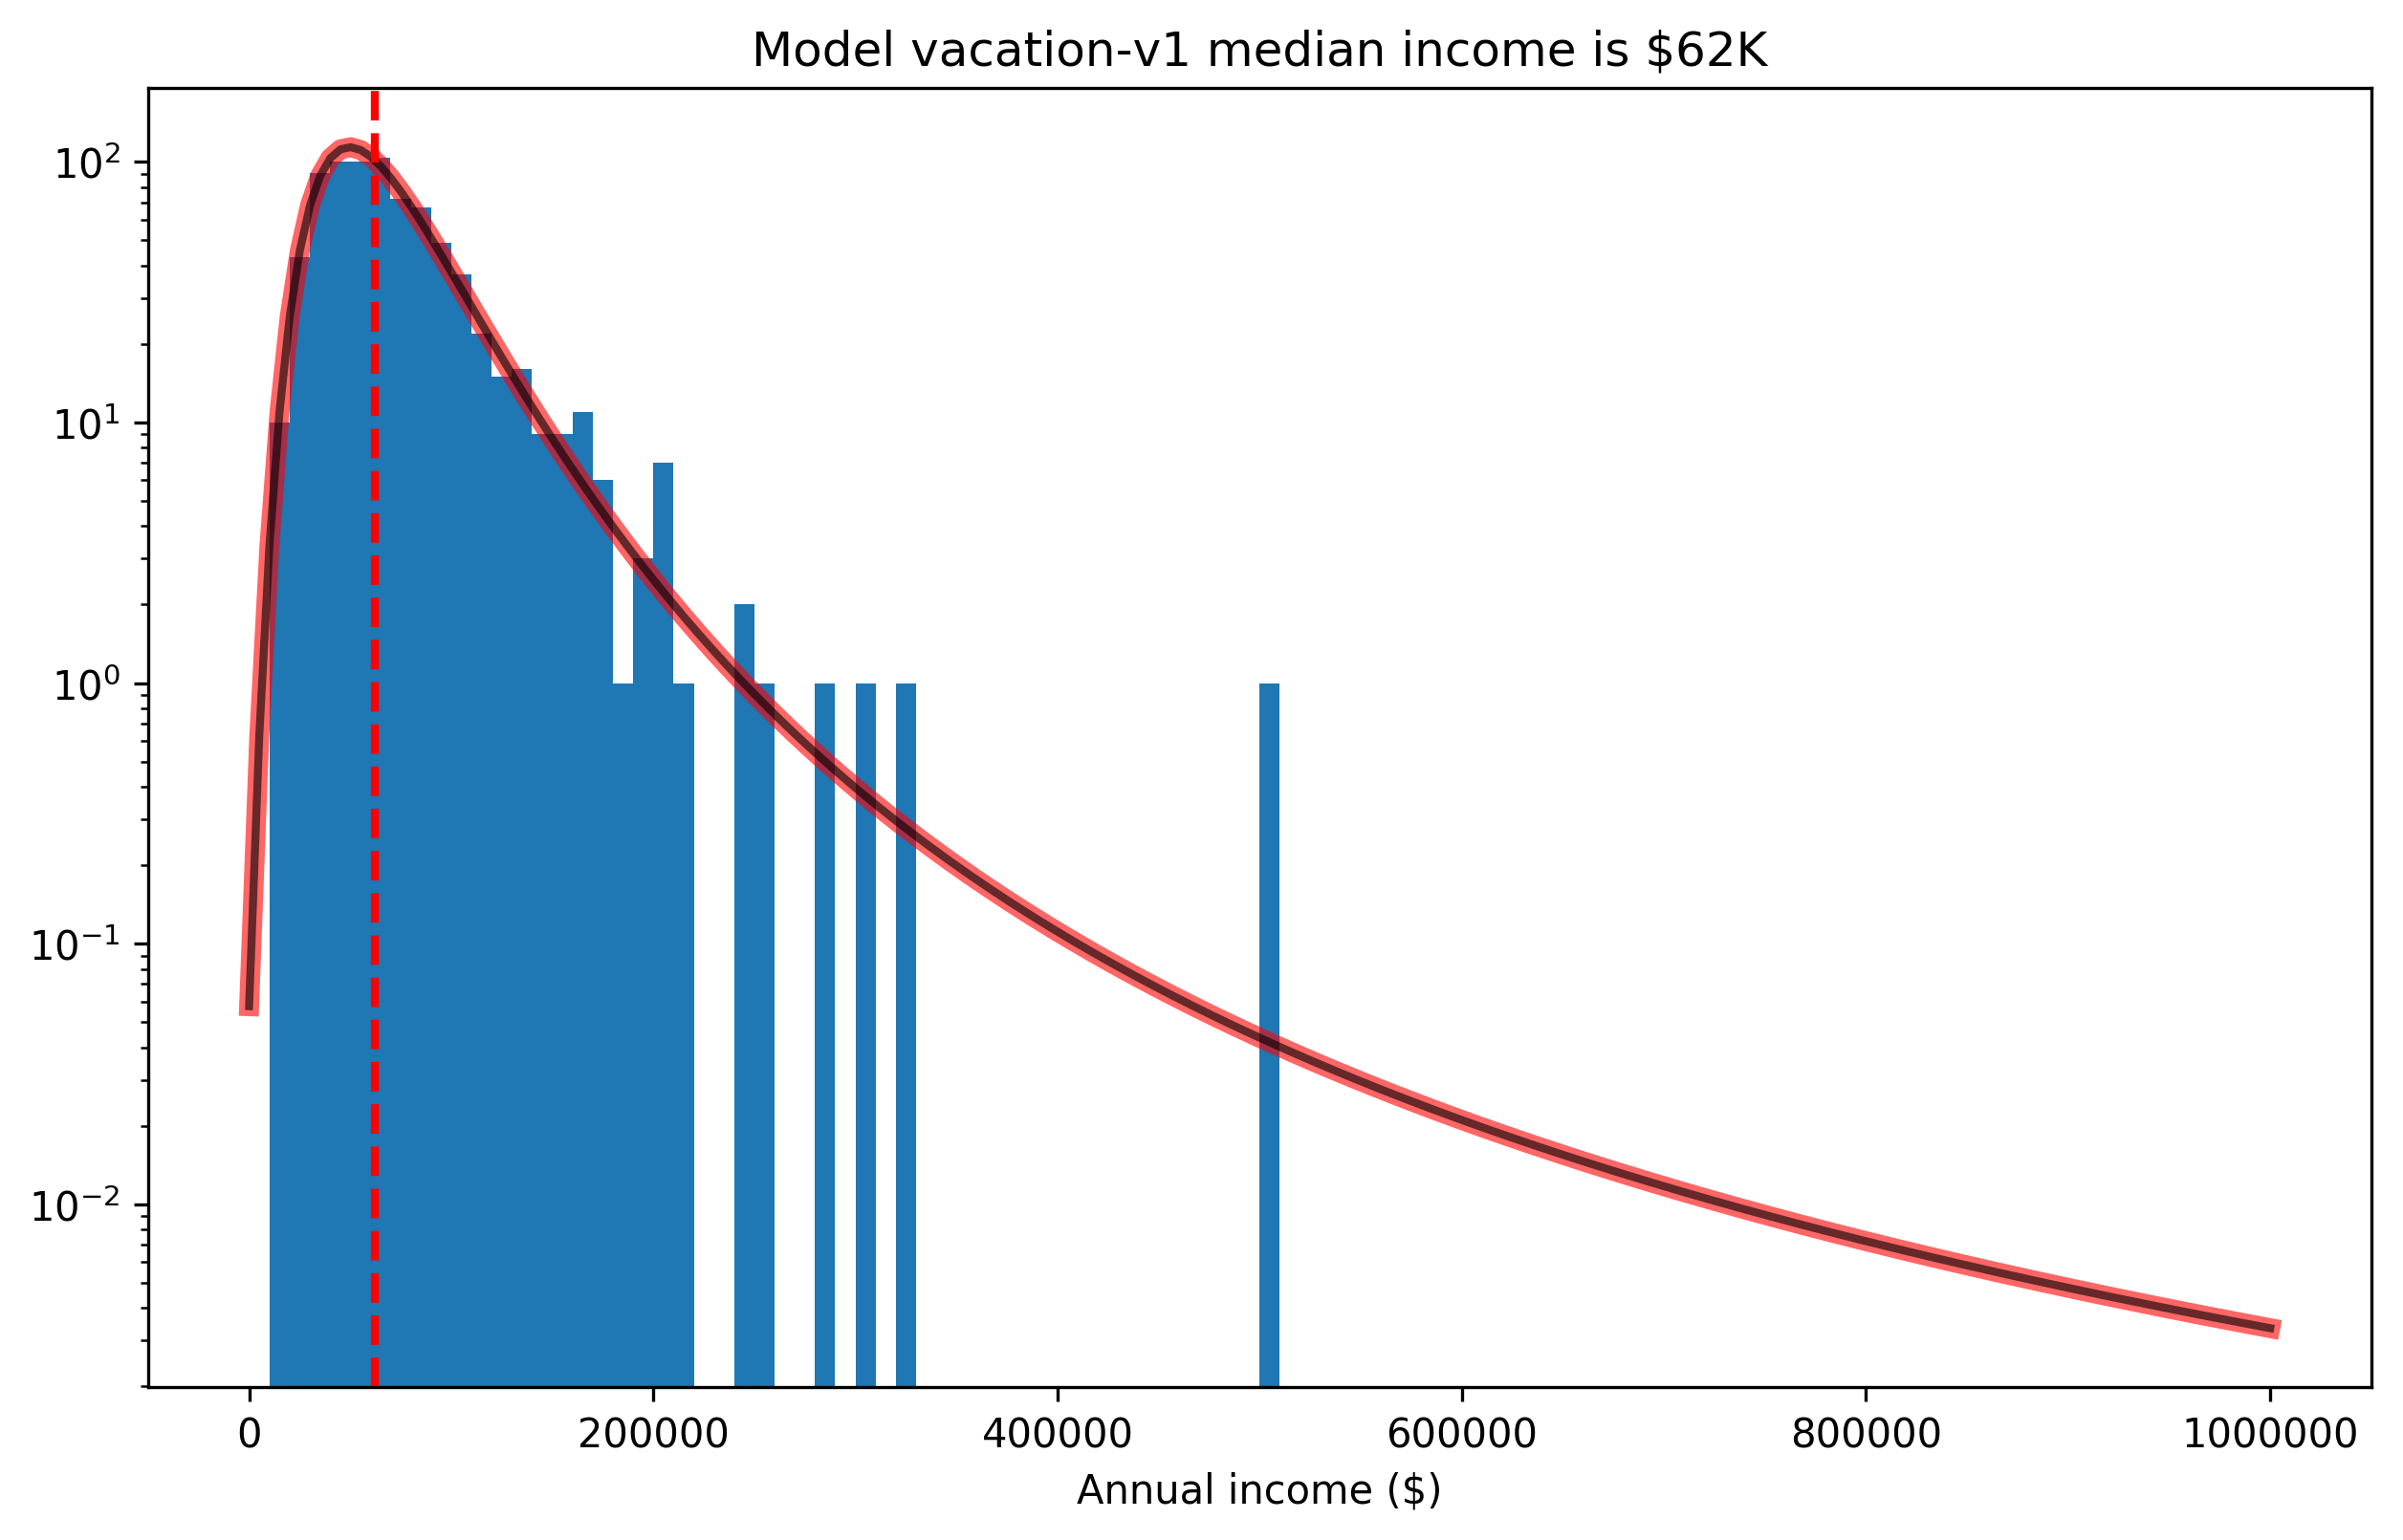

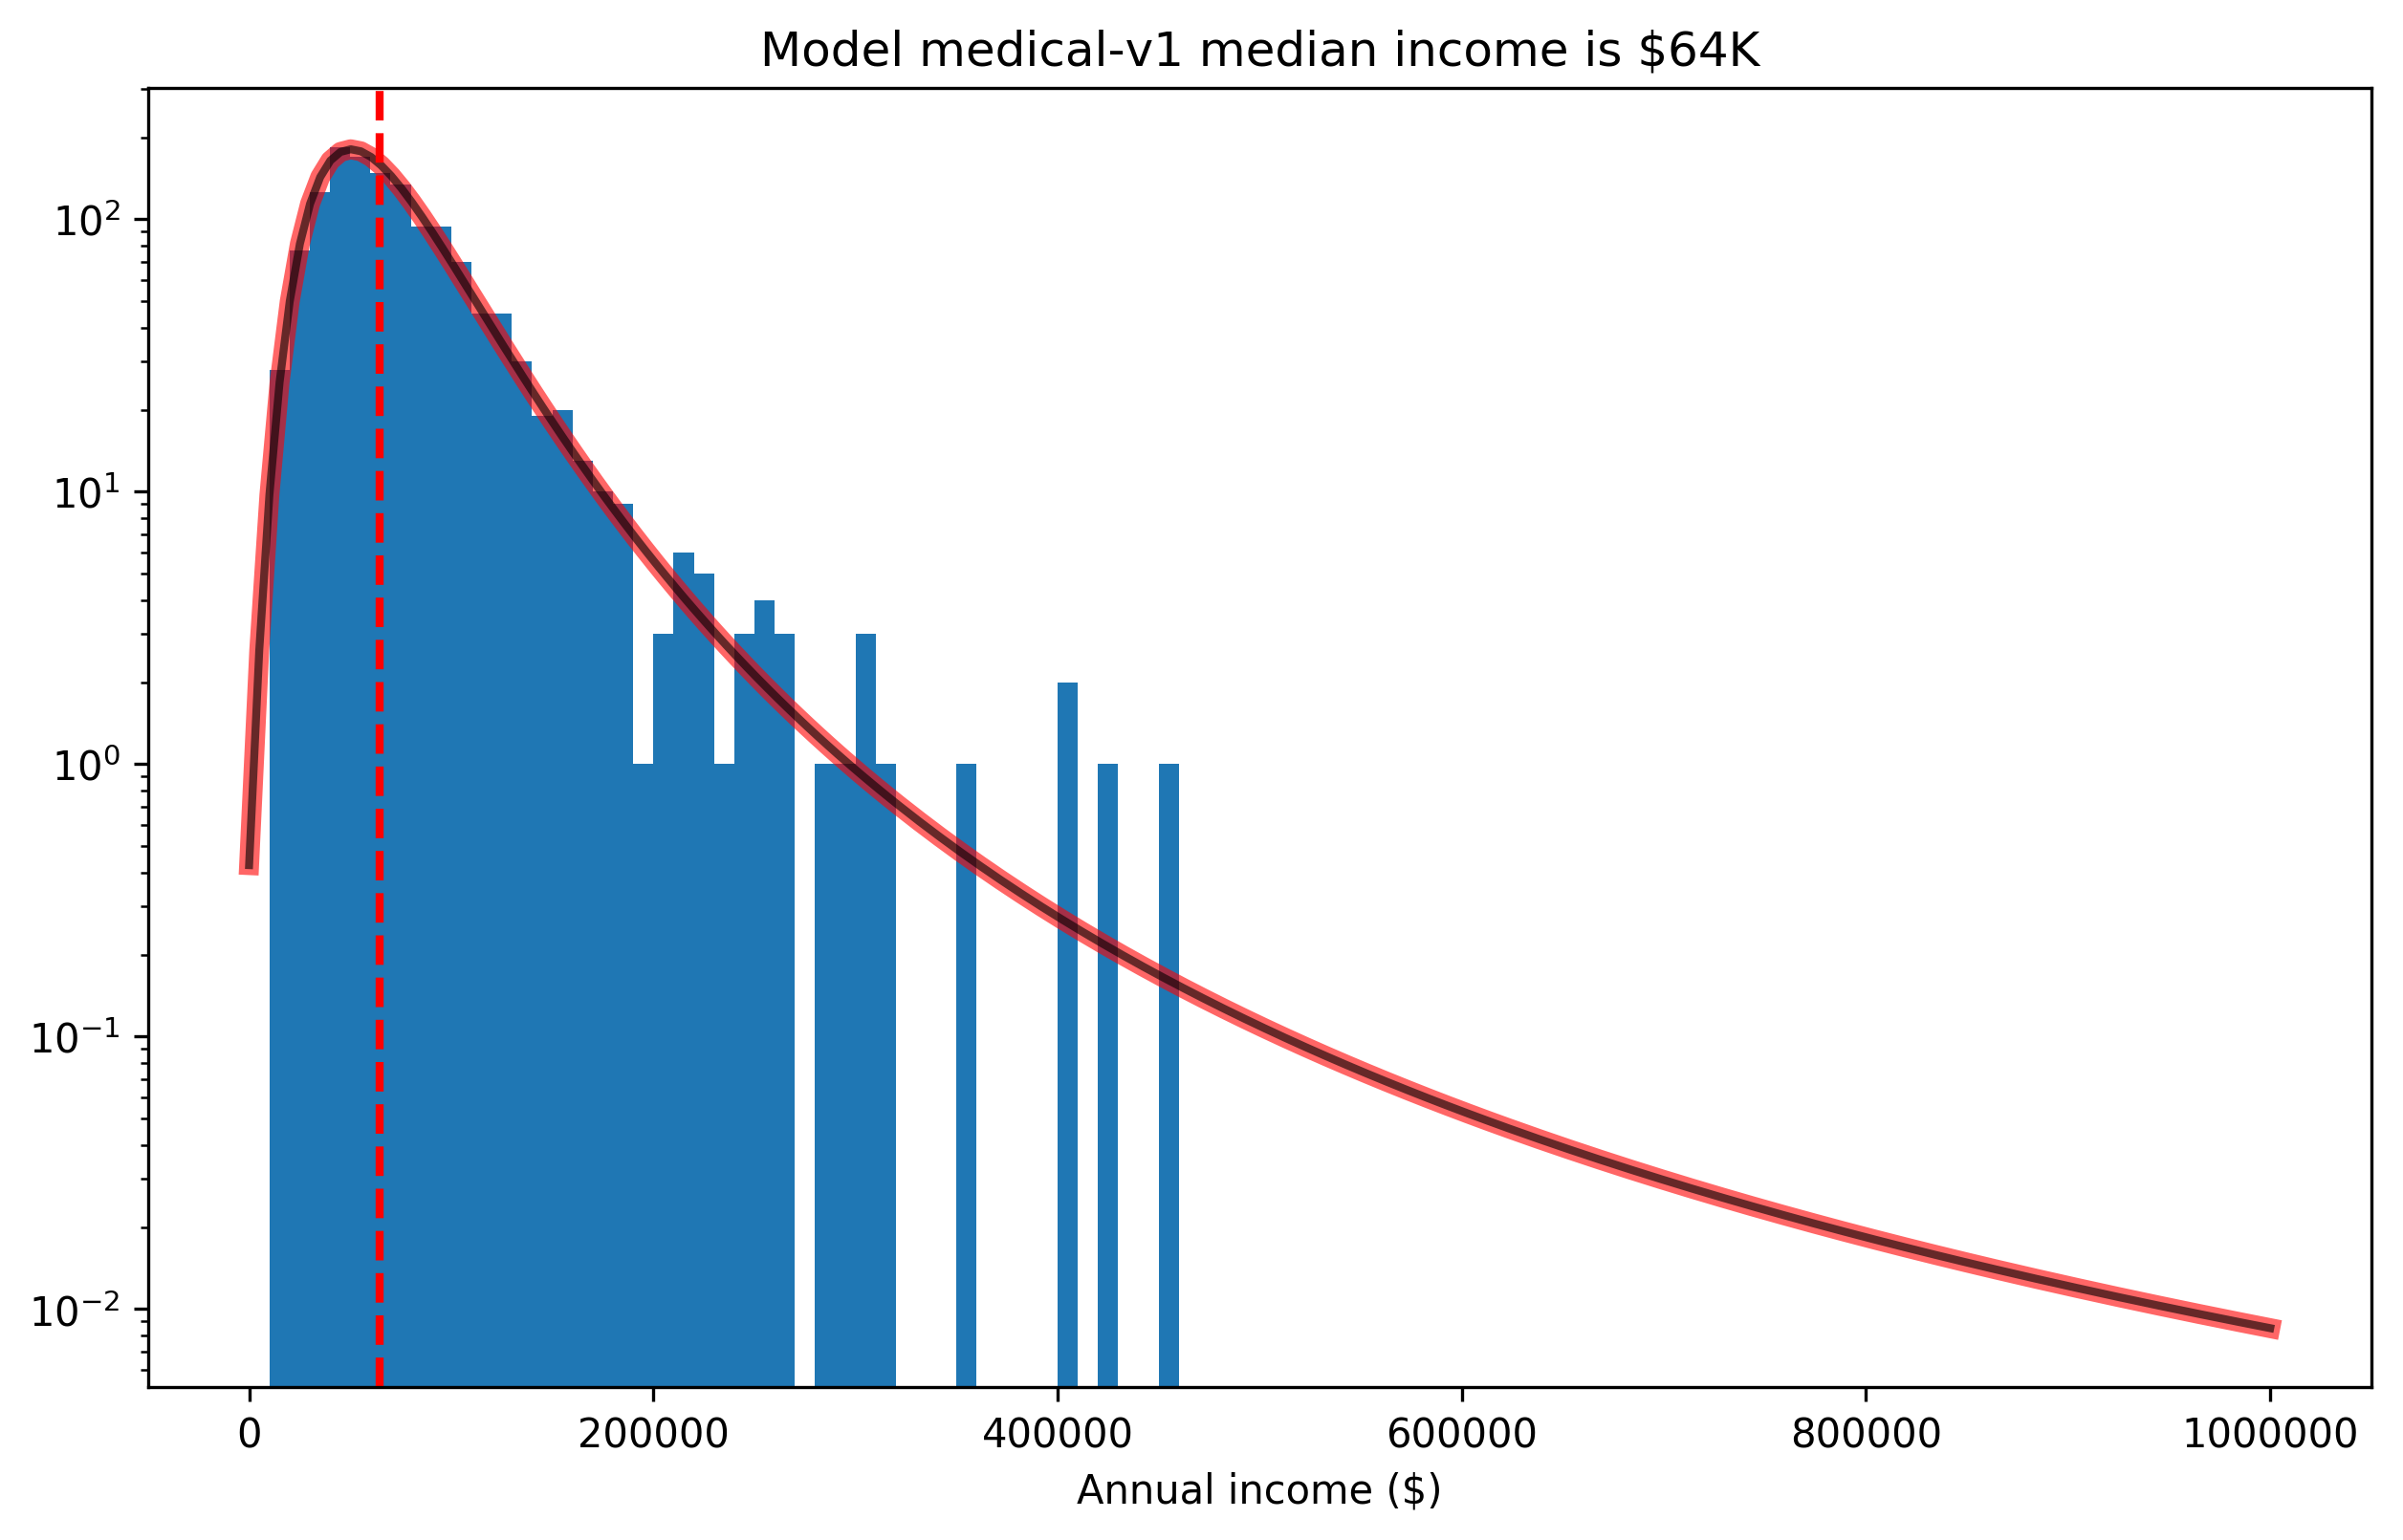

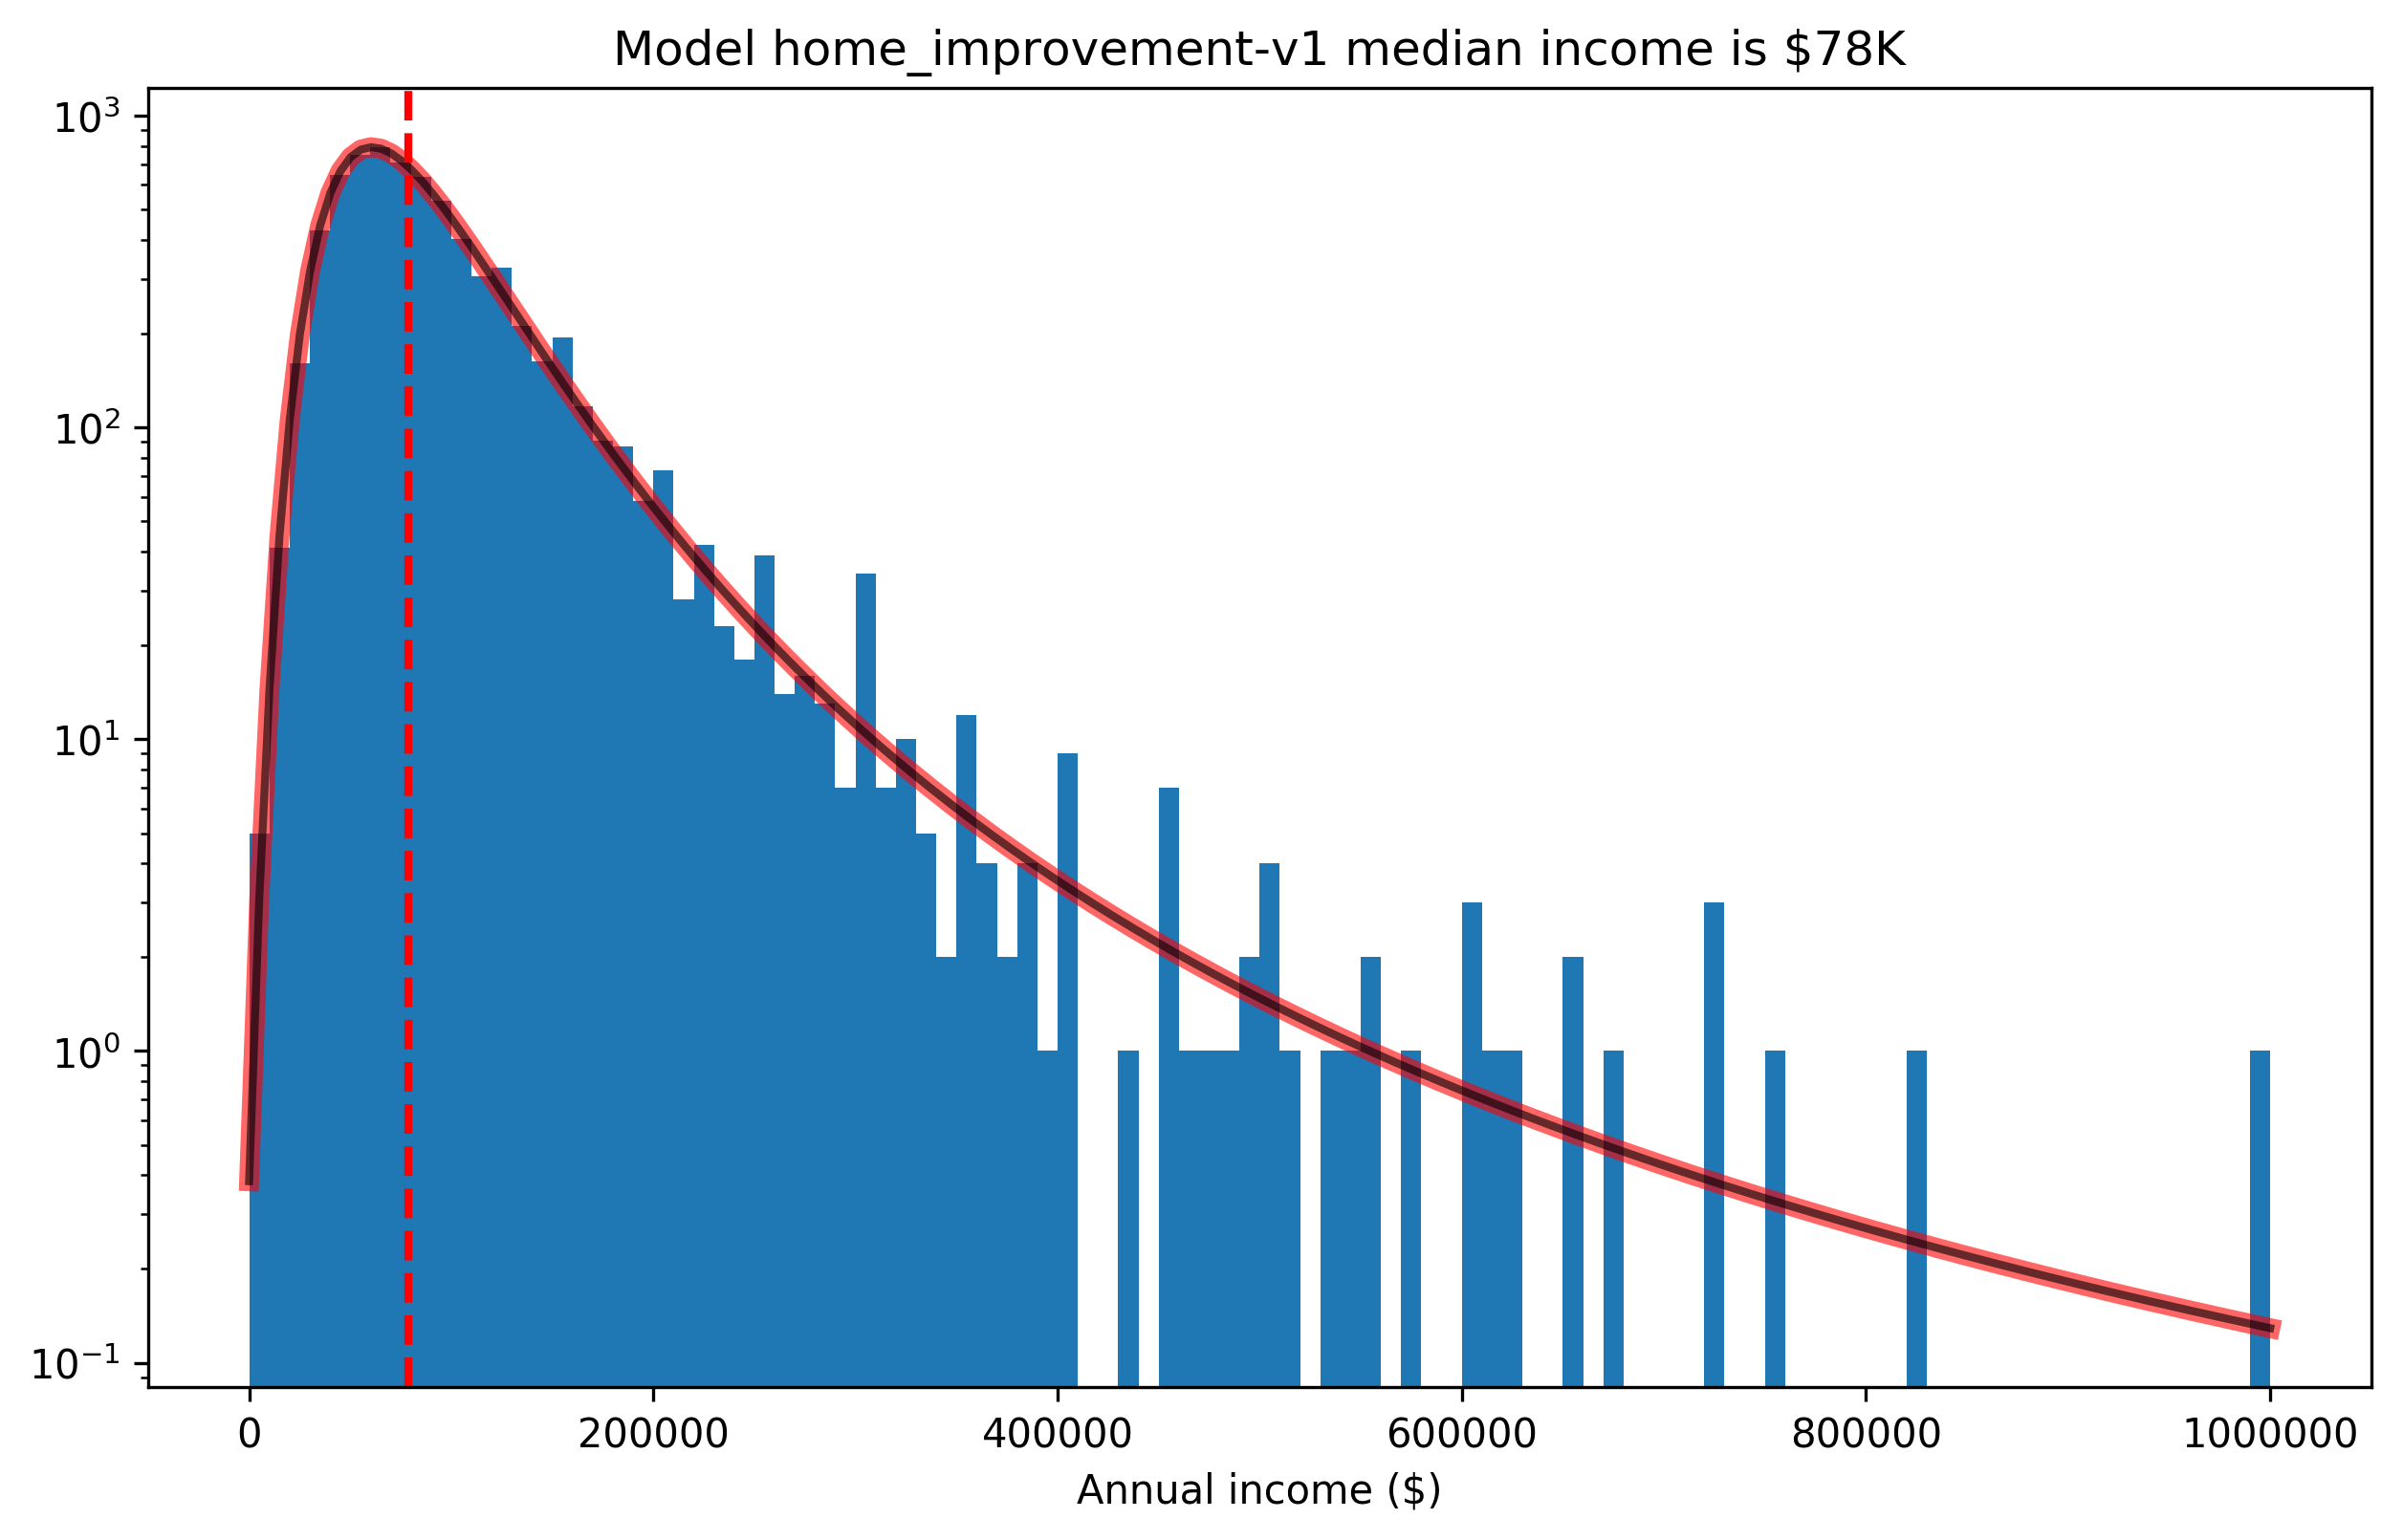

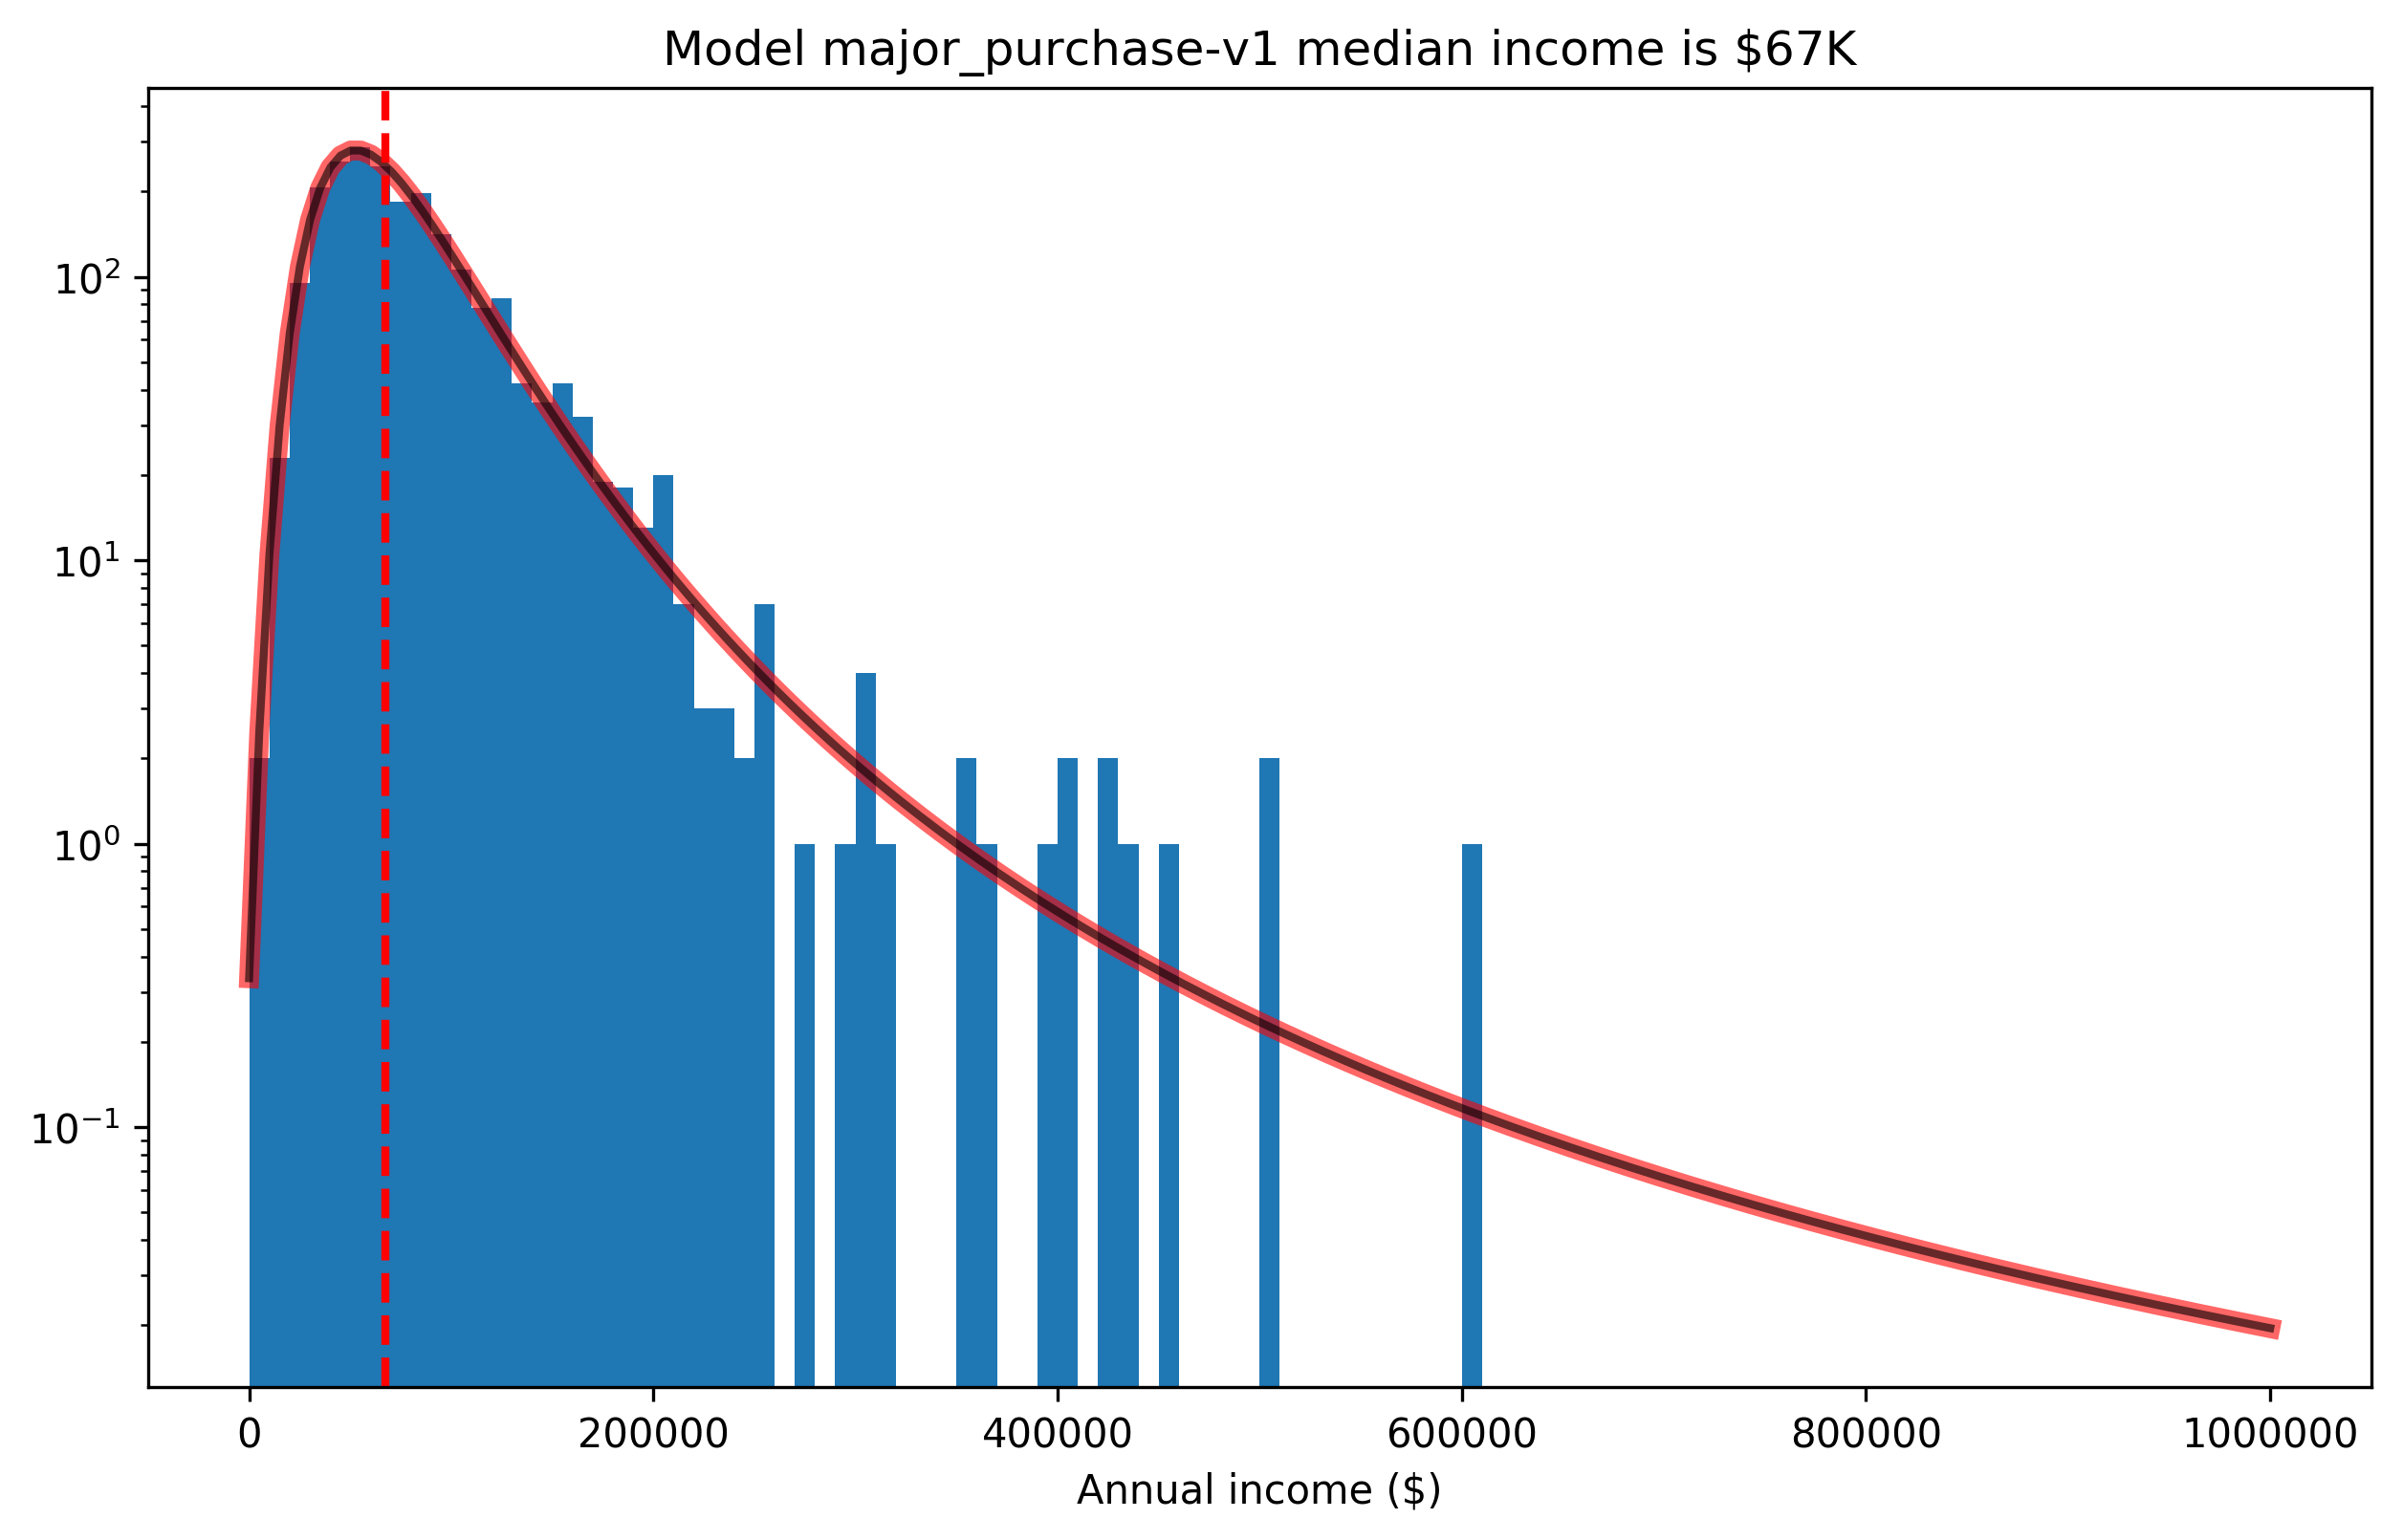

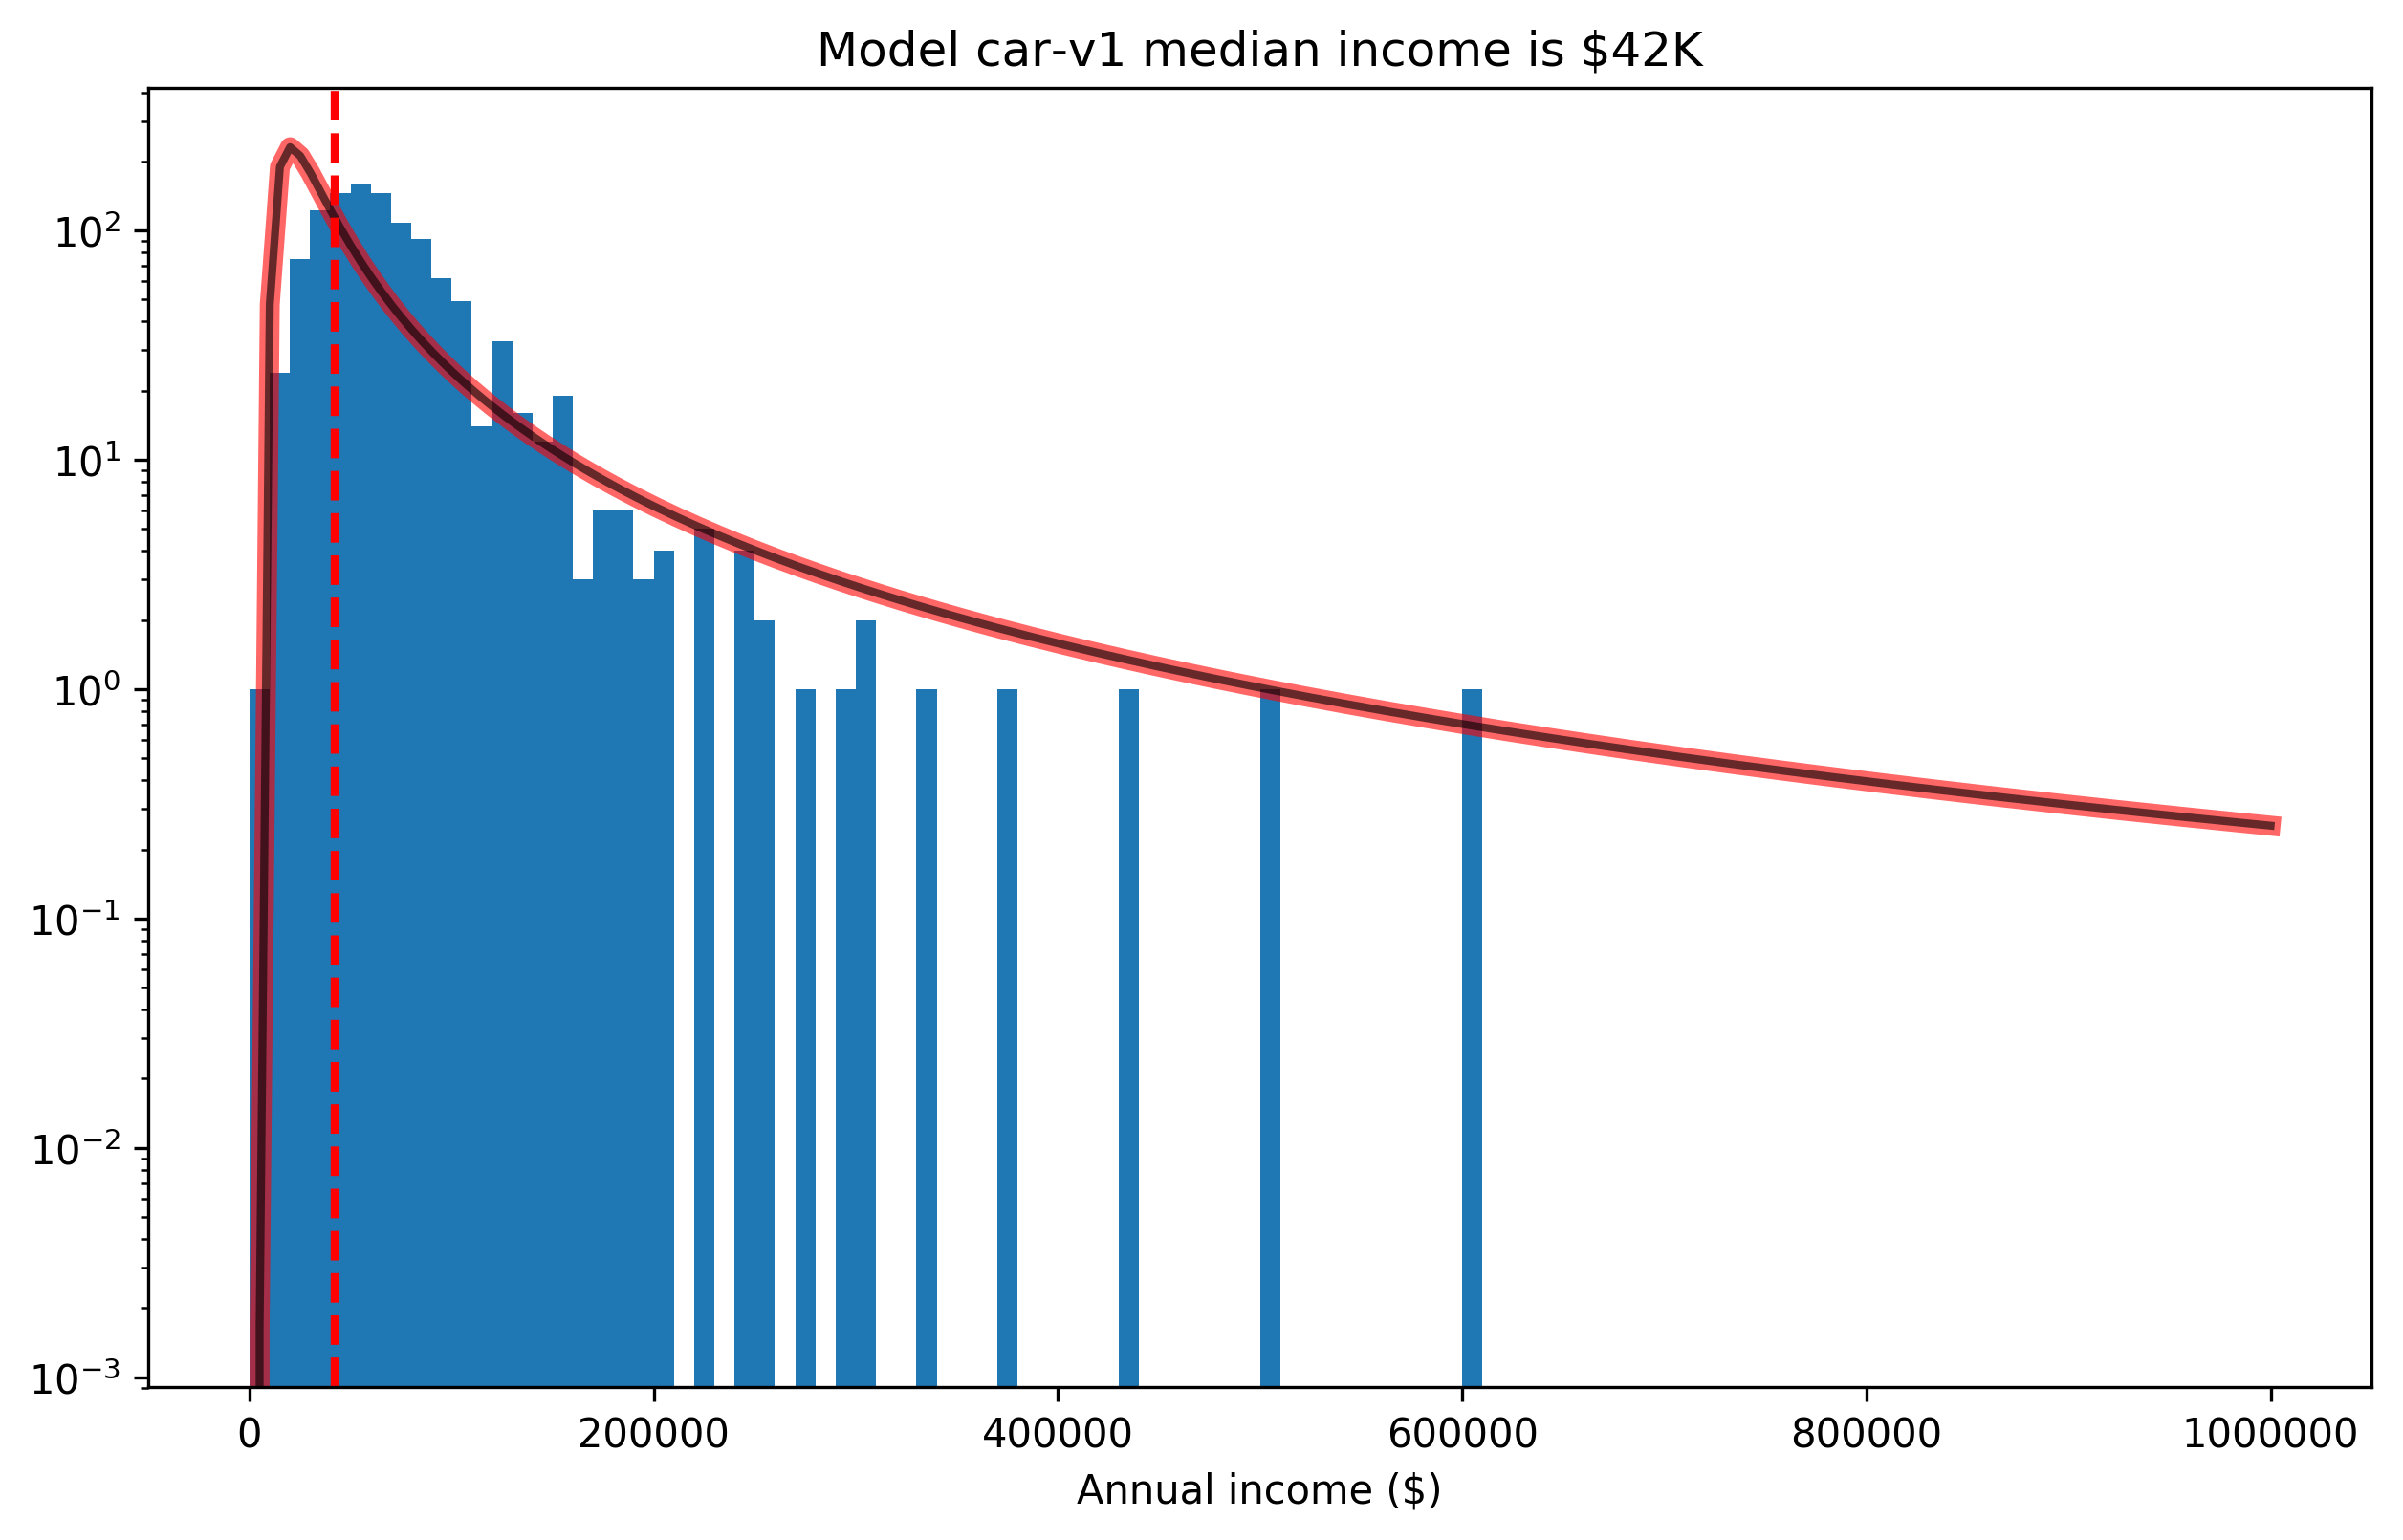

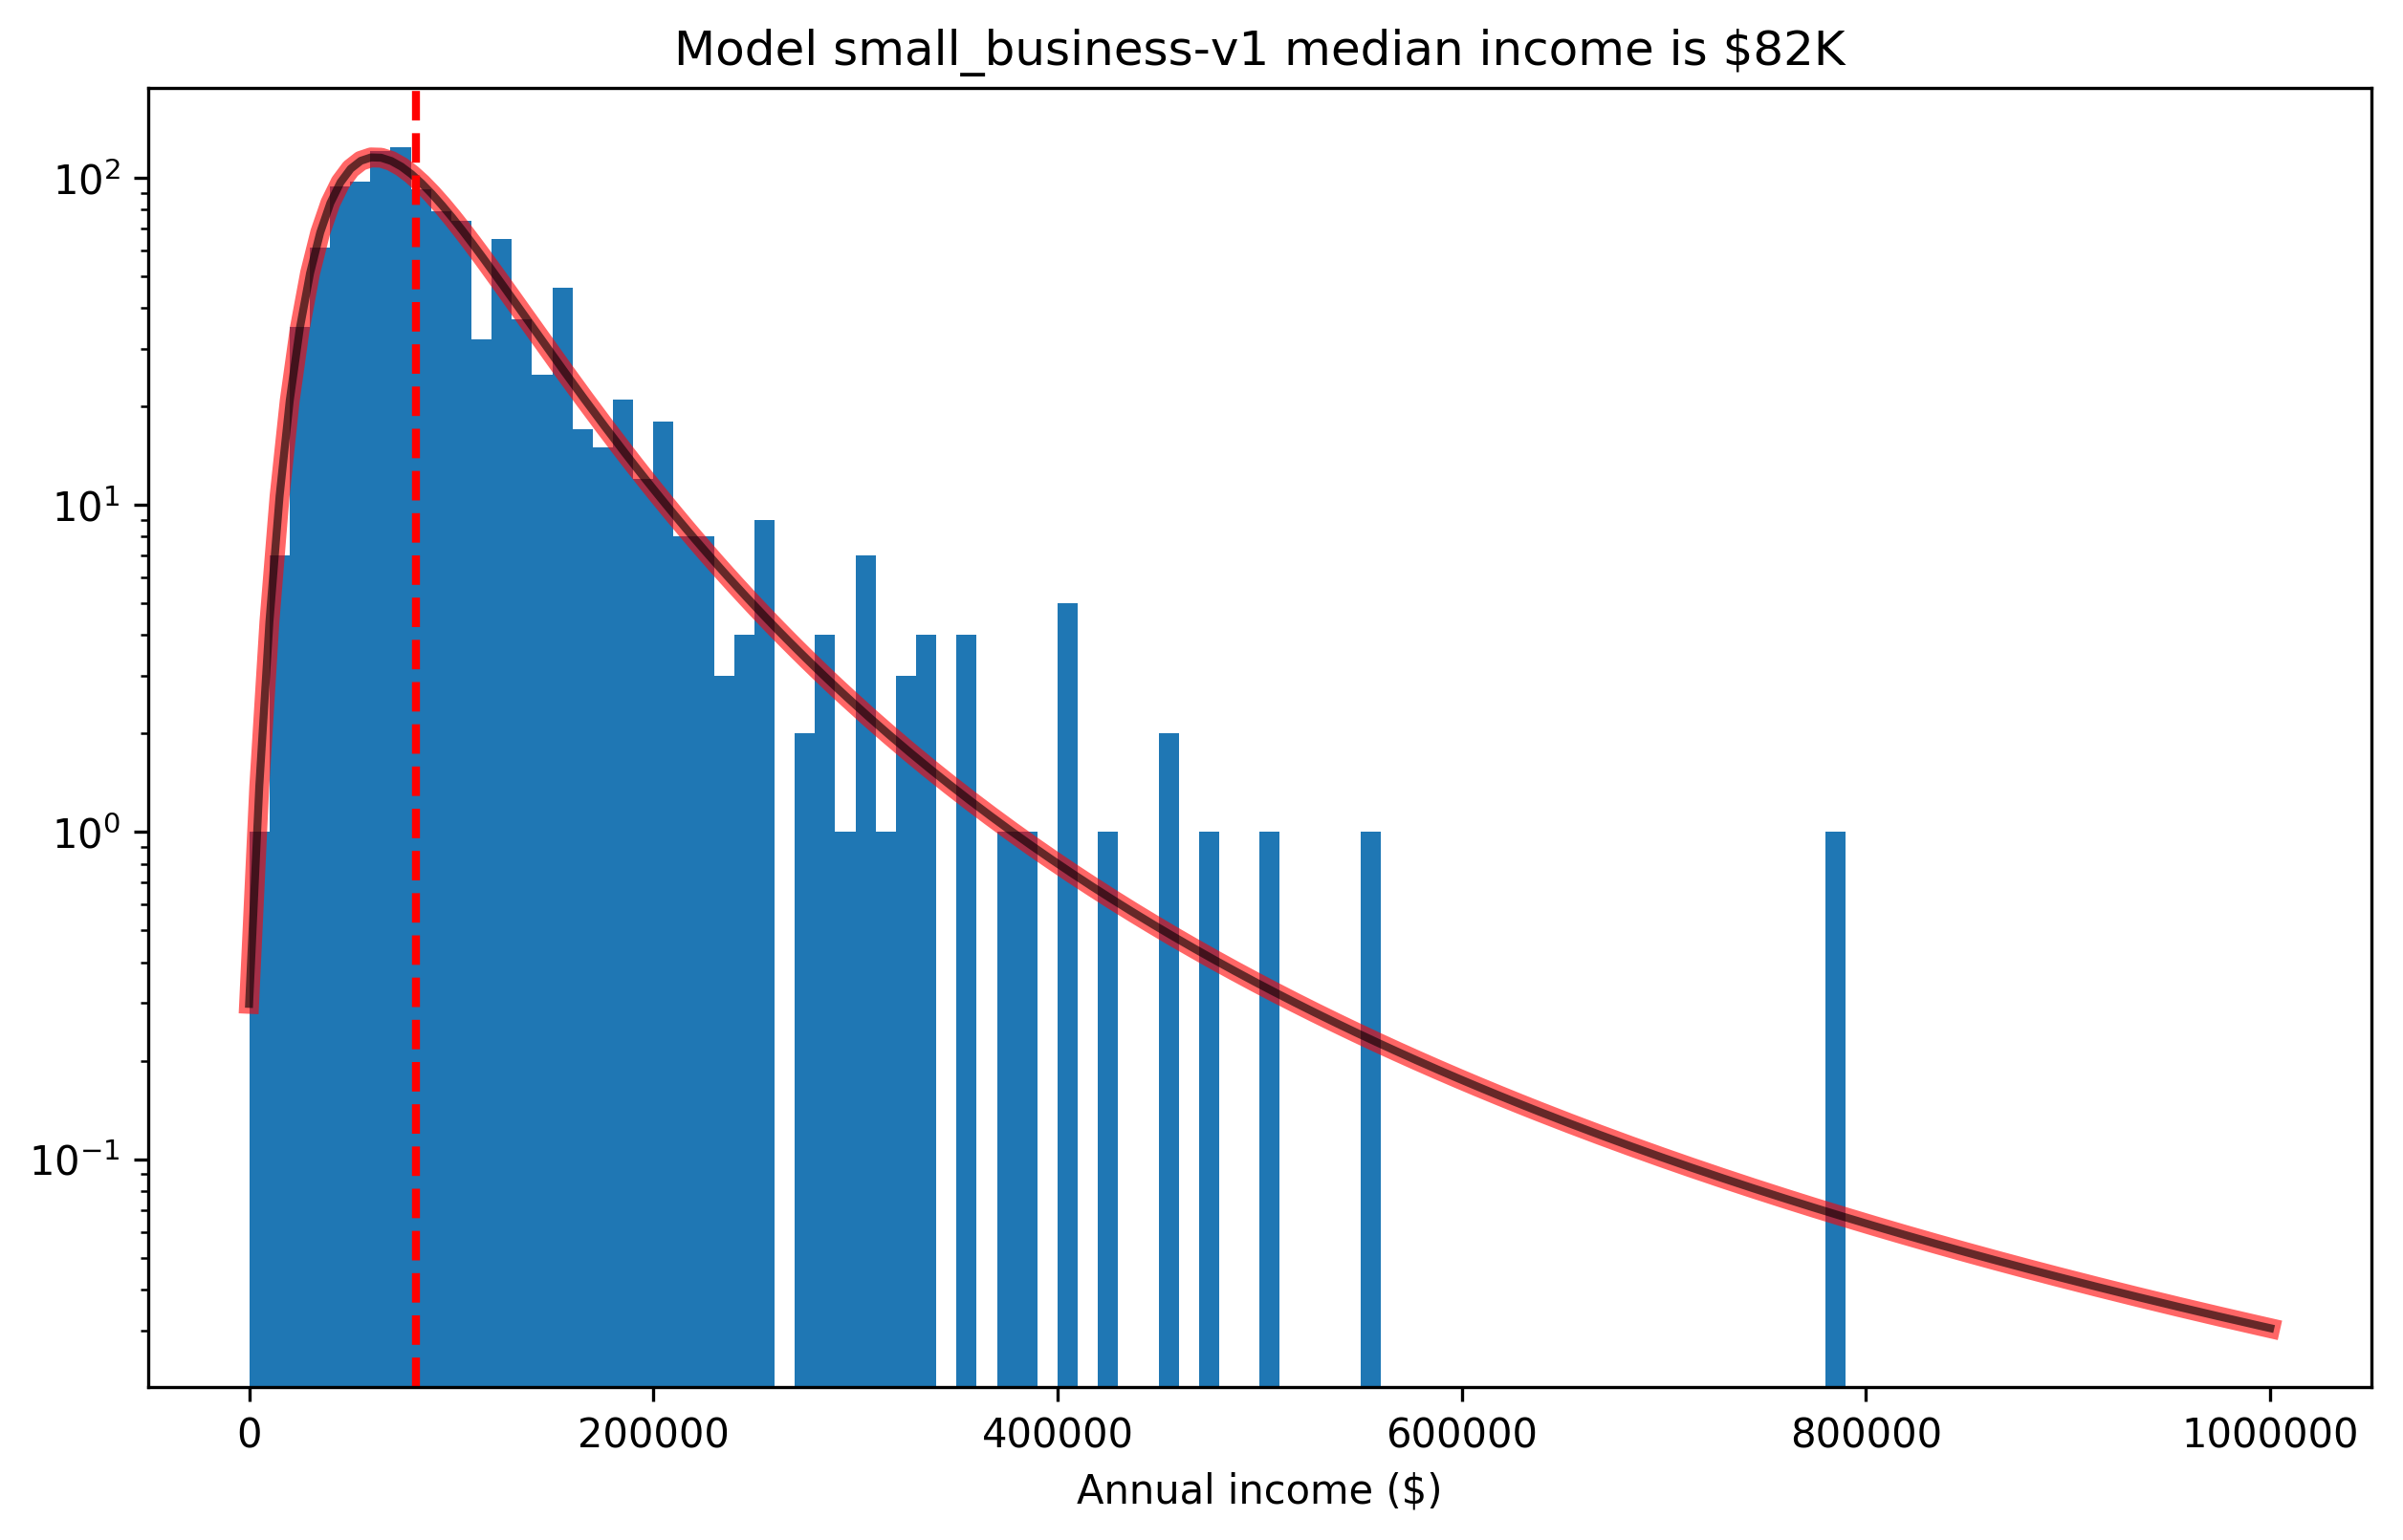

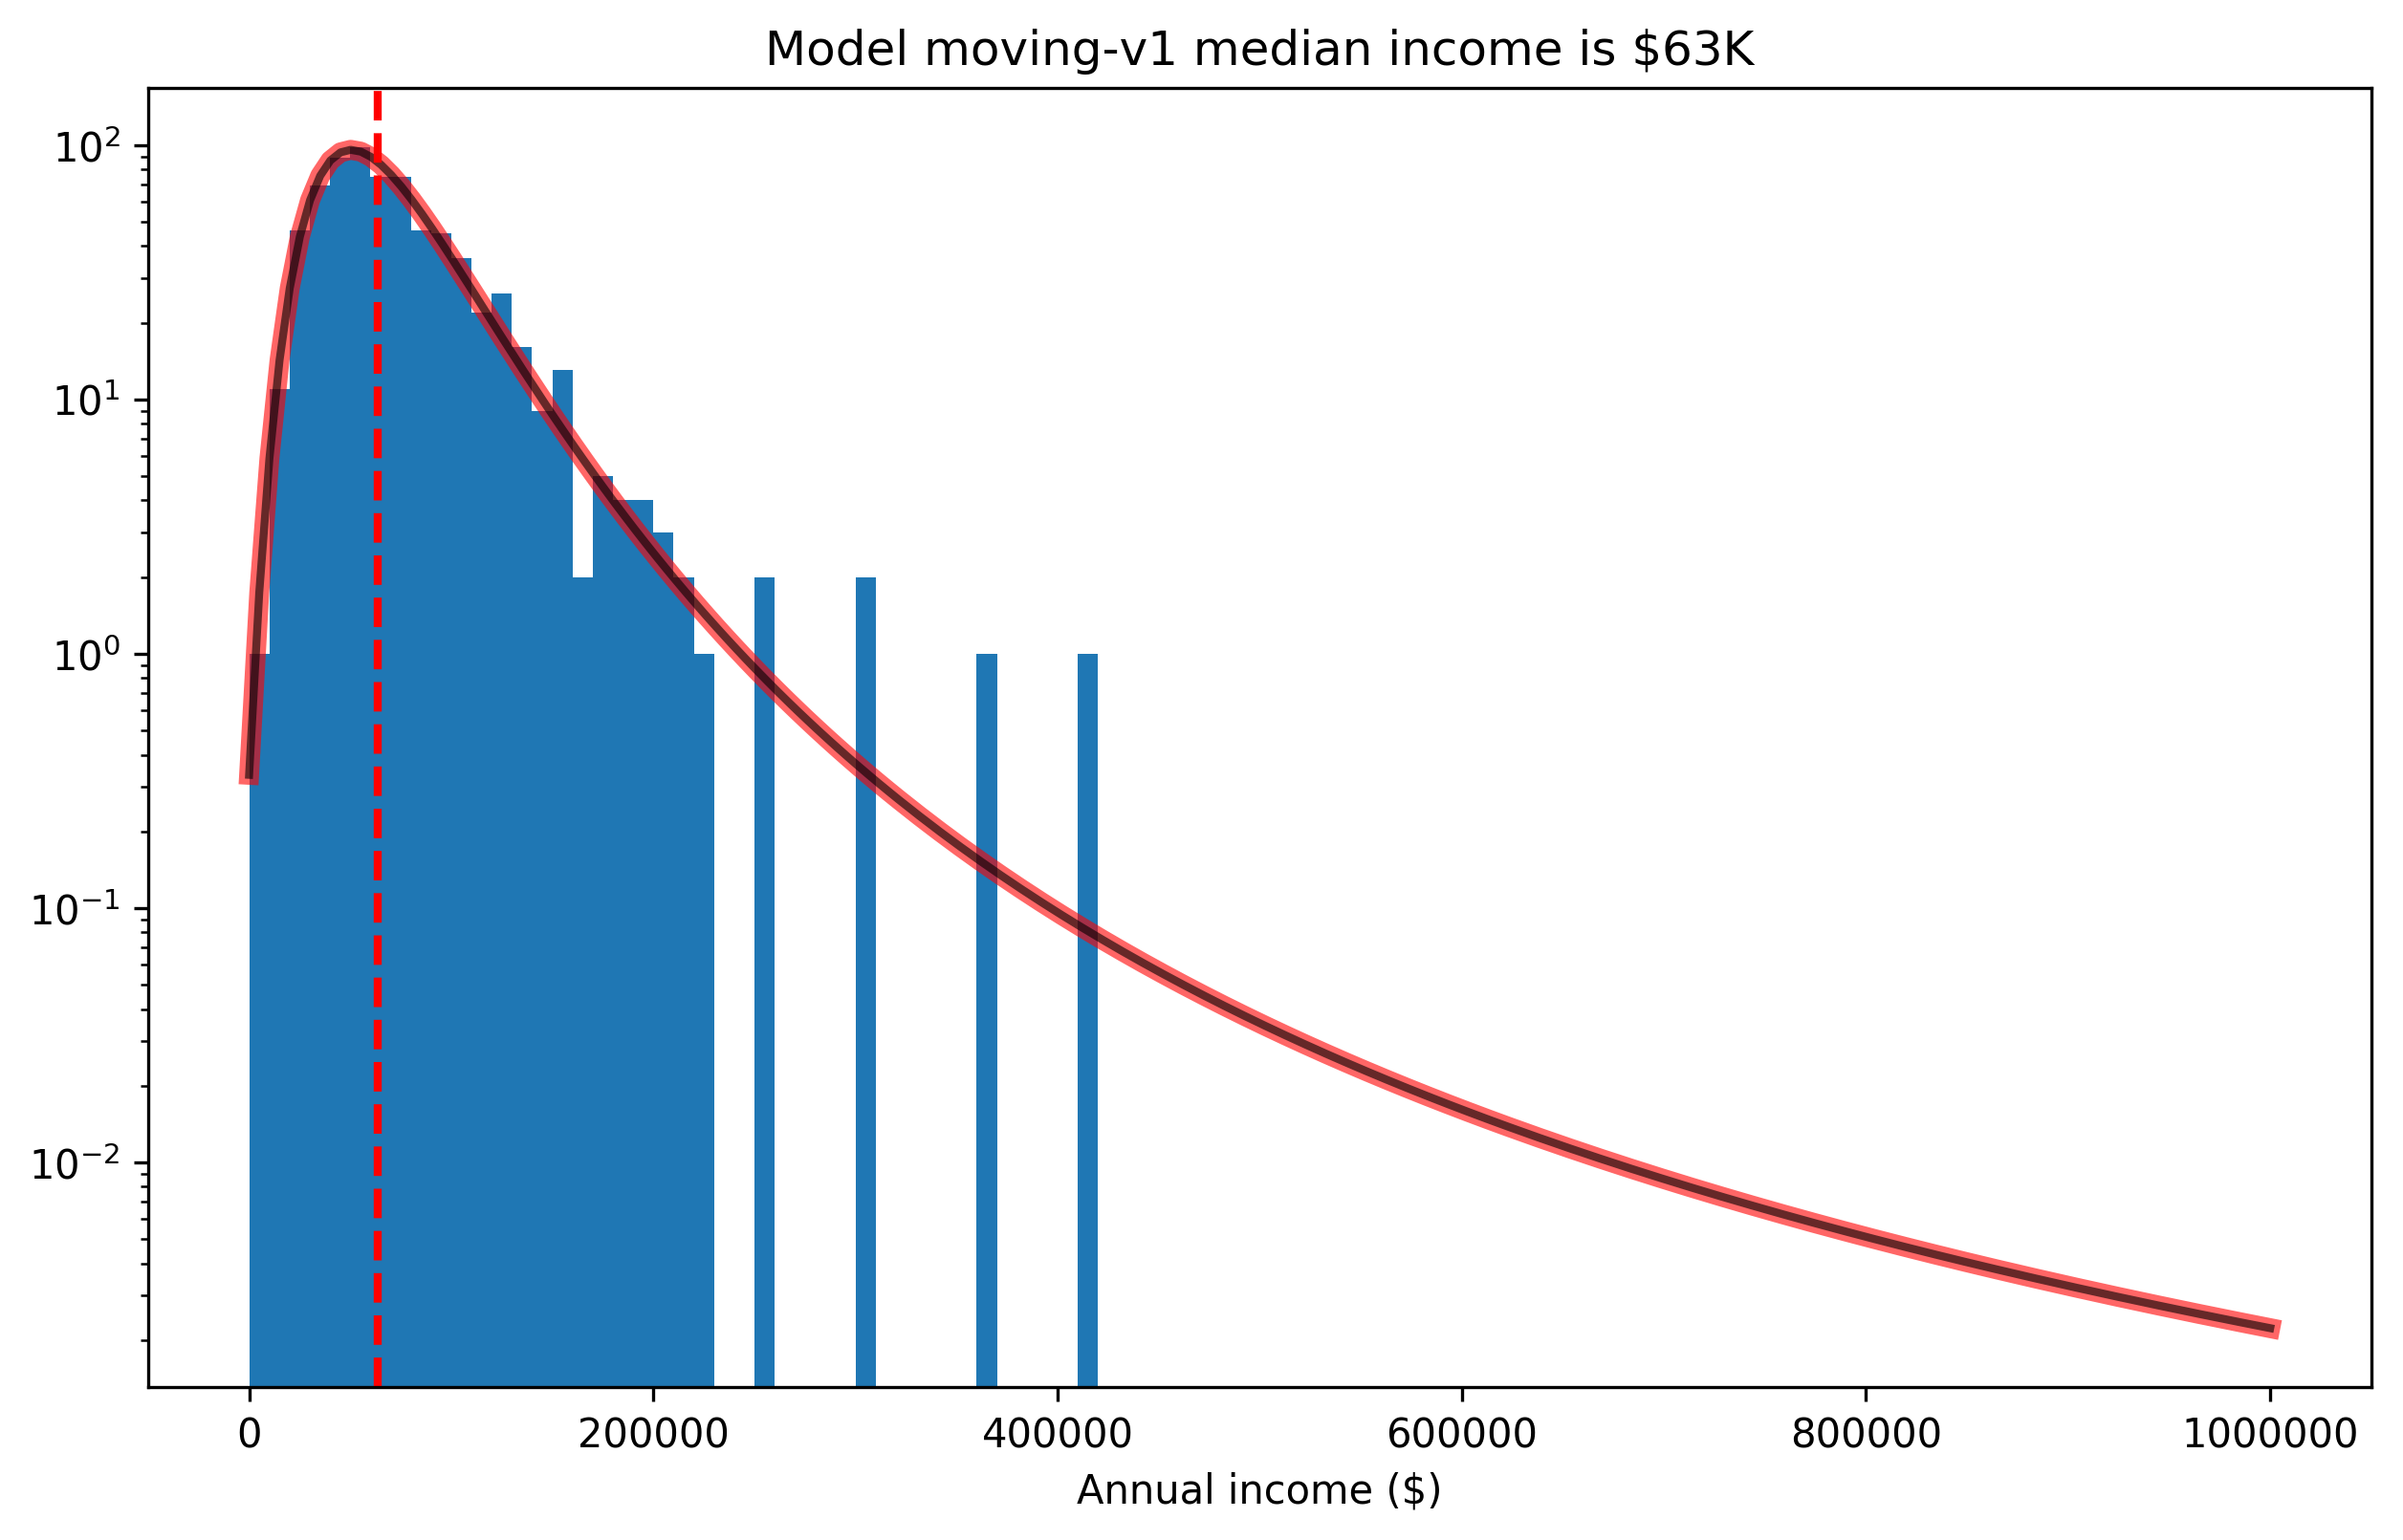

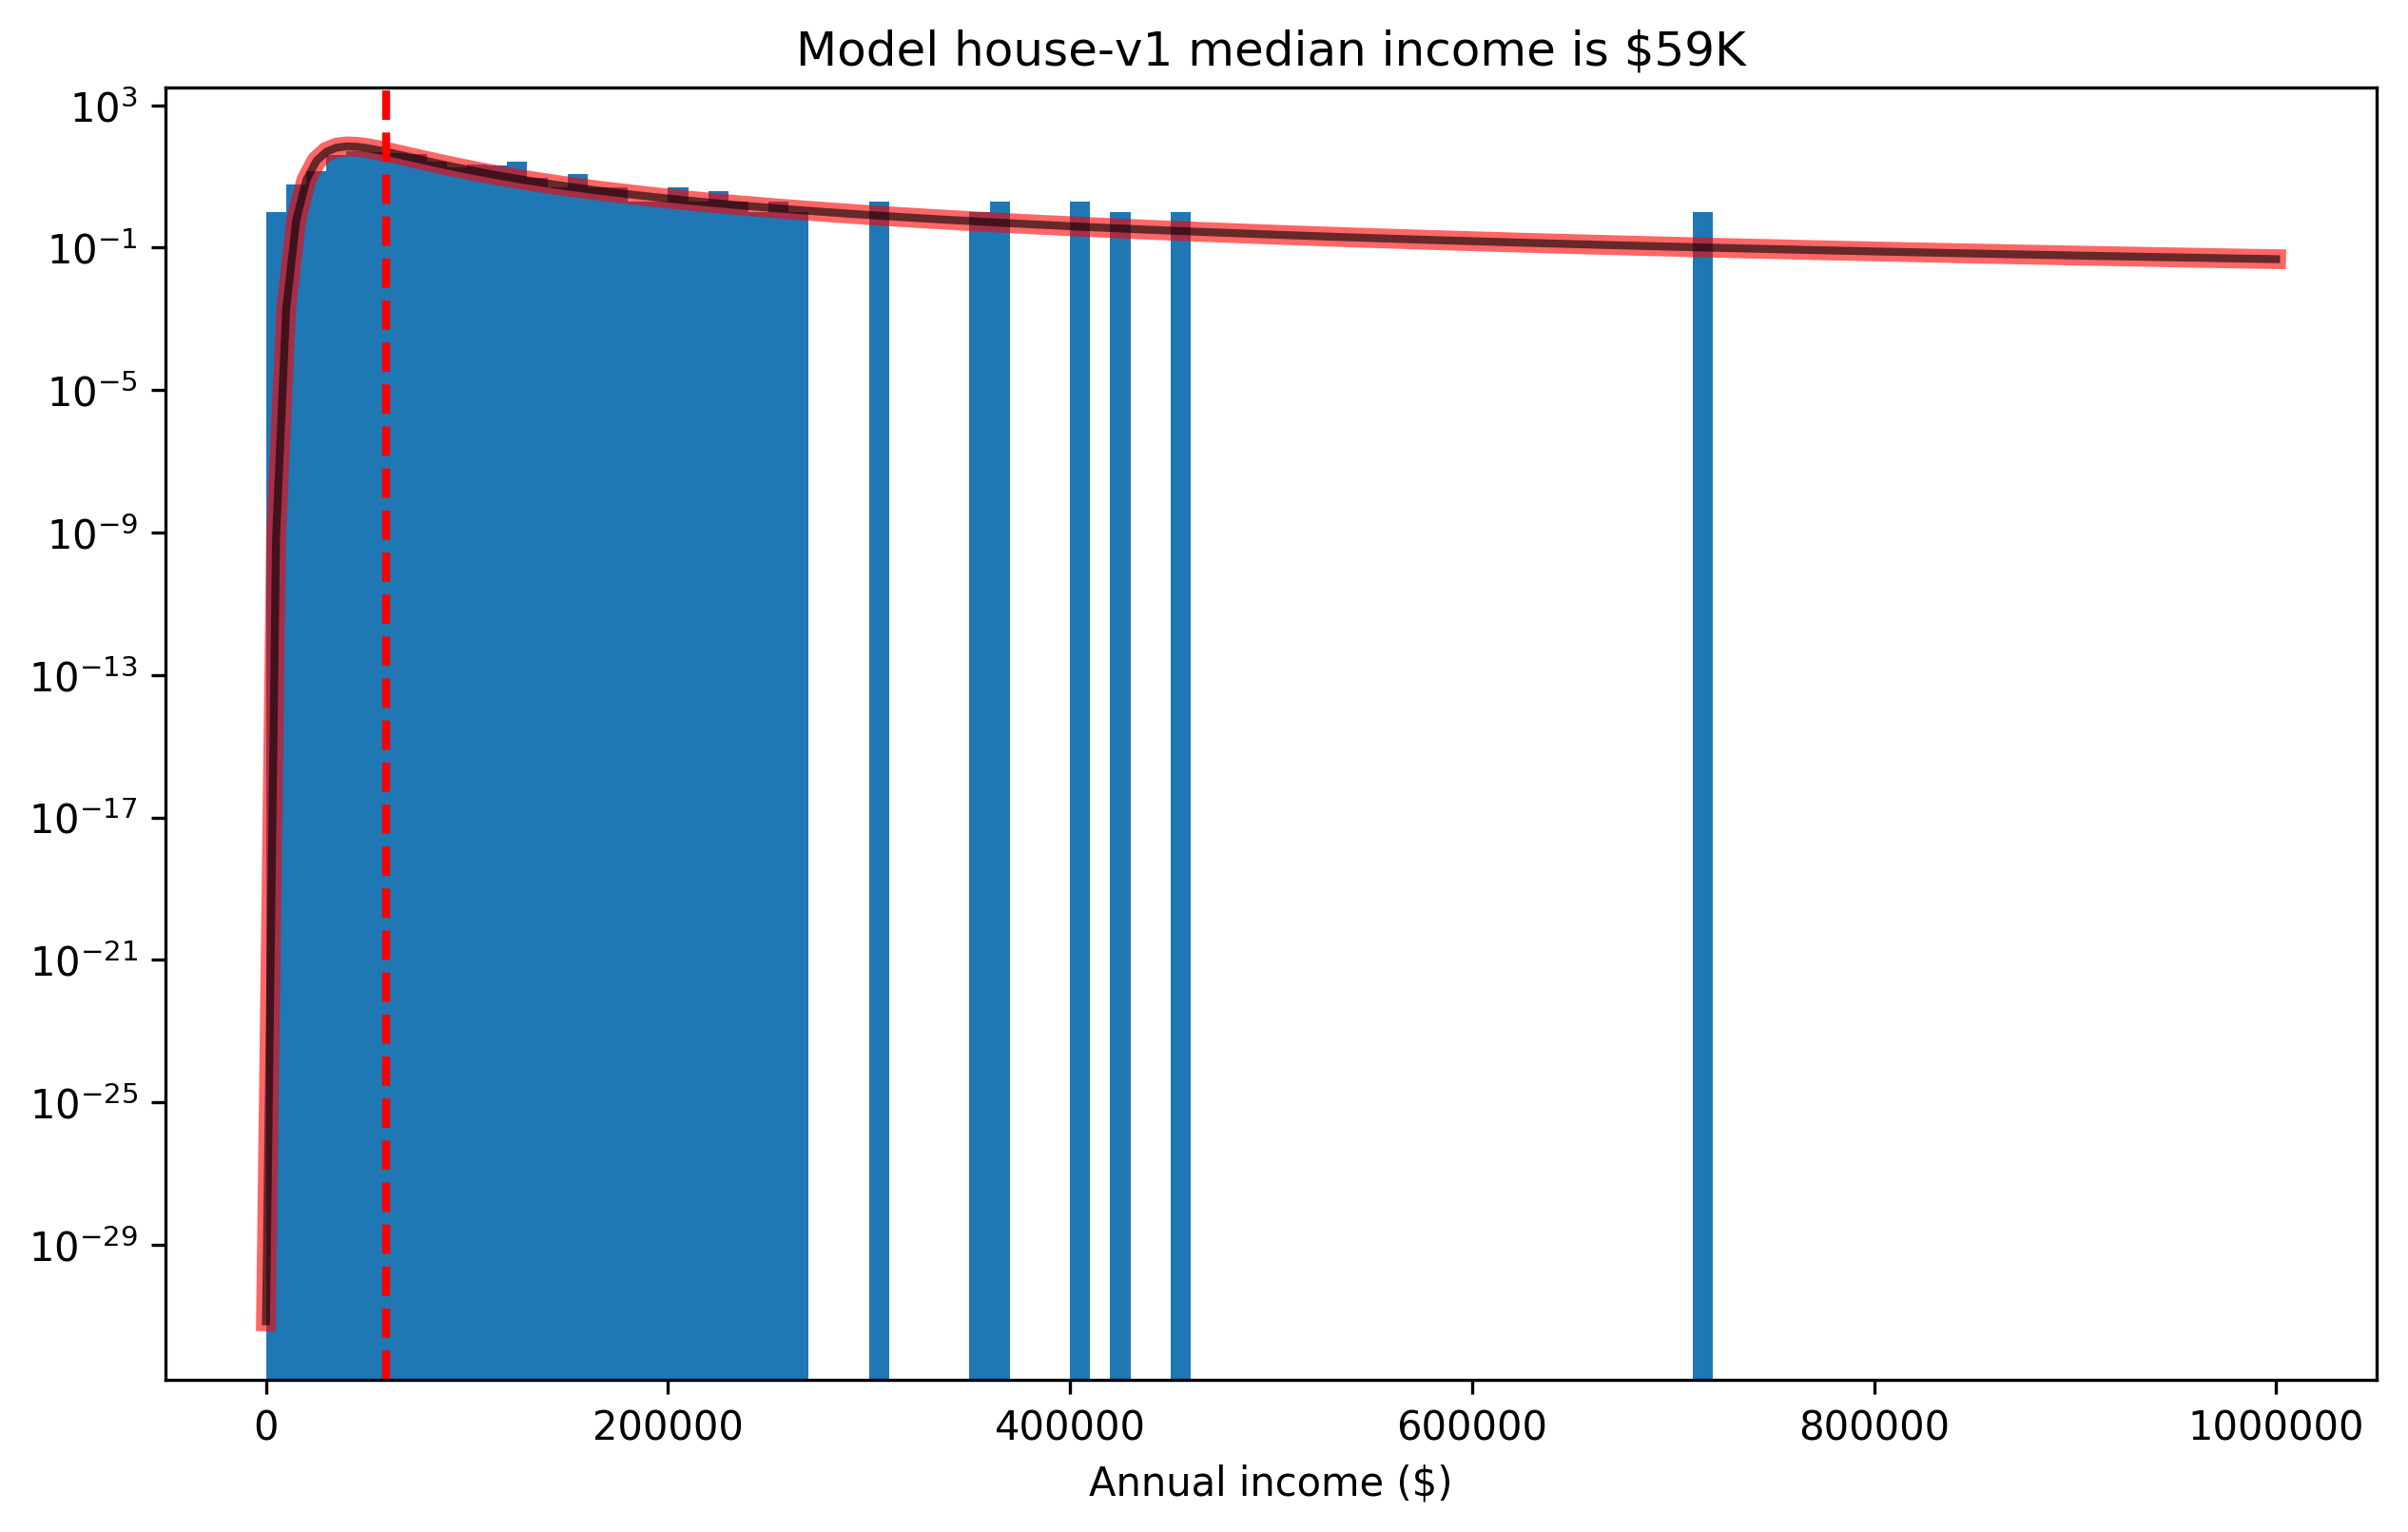

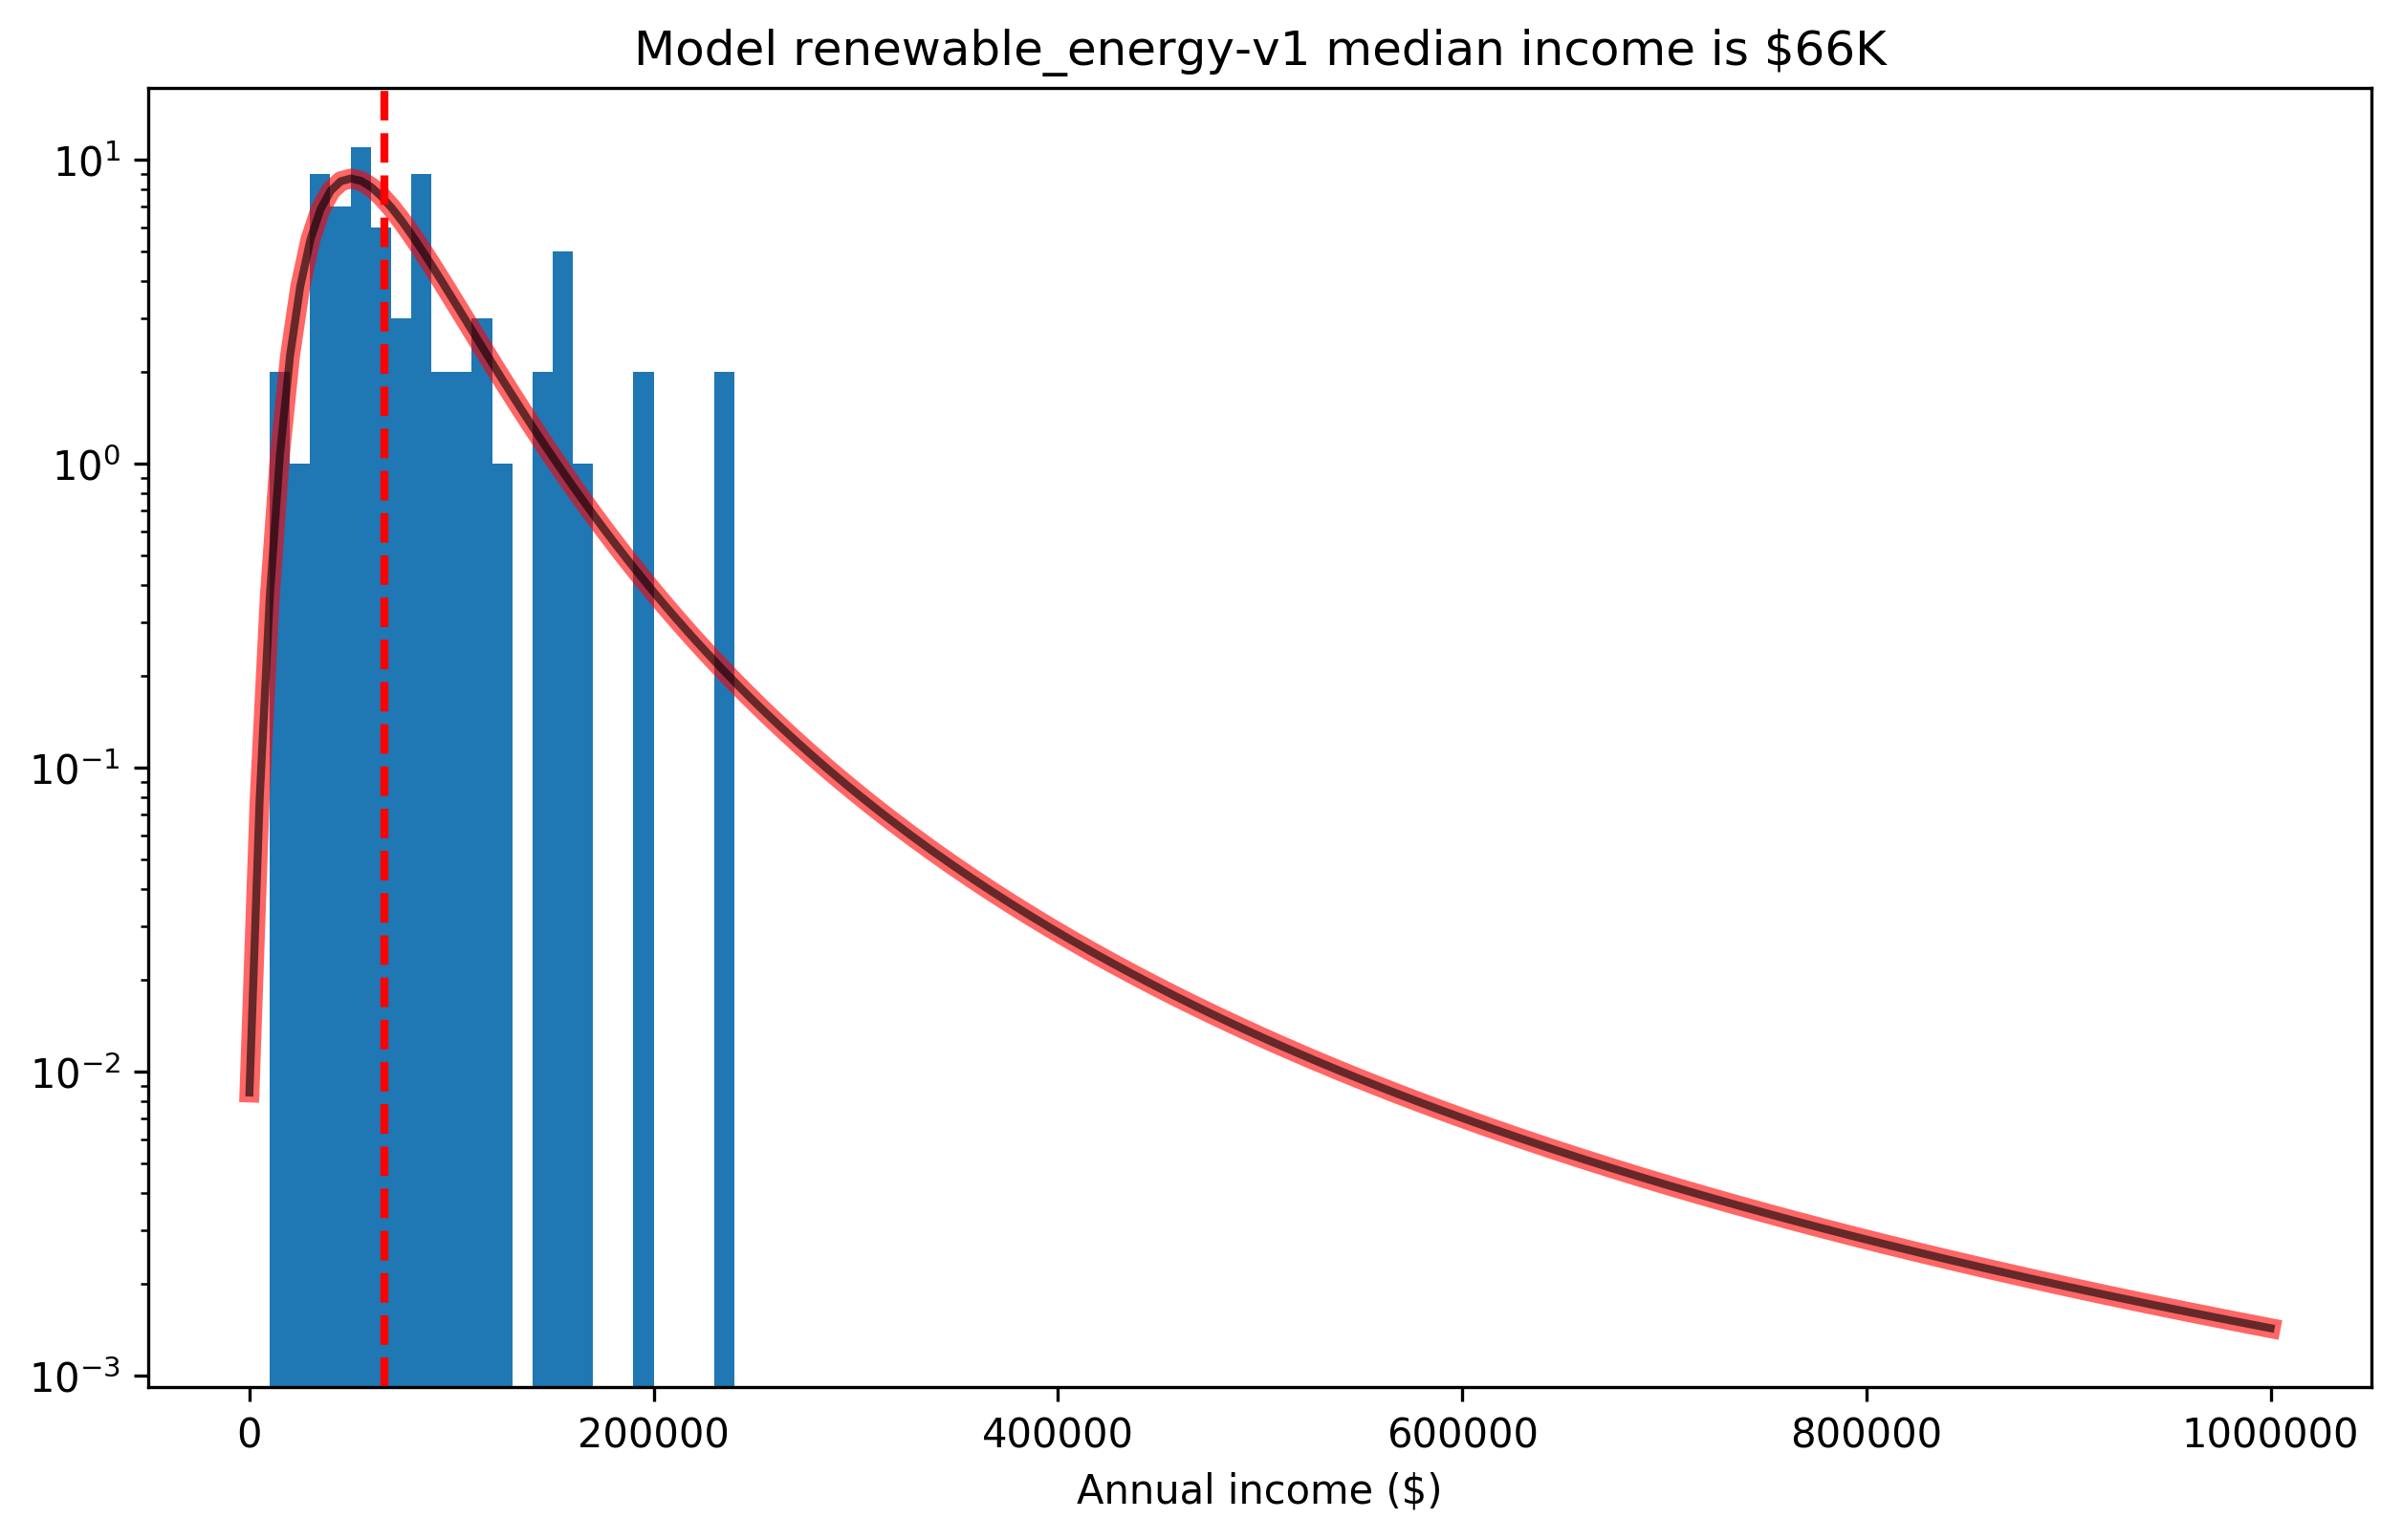

In [8]:
for purpose in loan_purposes:
    df_income = df_loans['annual_inc'][(df_loans['purpose'] == purpose) & (df_loans['annual_inc'] > 5.)]
    incomes = df_income.dropna().as_matrix()

    print('')
    print('Loan purpose:'+purpose)
    myModel2 = IncomeDistributionModel(purpose+'-v1')
    myModel2.fit(incomes)
    myModel2.inspect()
    print(myModel2.classify(0))
    print(myModel2.classify(500e3))
    print(myModel2.classify(800e3))
    print(myModel2.classify(2000e3))